# Alumno: Oscar Mateos López

# **Ejercicios NLP (primera parte) Para evaluar la primera parte del módulo de PLN se proponen dos ejercicios**
 
Ambos ejercicios utilizan el corpus de críticas de cine "mundocine". 

Estas críticas están almacenadas en archivos XML en un formato que ya se ha visto el el notebook NLP_07.

# **Puesta a punto del entorno en Colab**
Los ejercicios se realizarán en Google Colab, por lo son necesarios los siguientes pasos para poder ejecutar los ejercicios. 

In [2]:
!pip -q install https://github.com/explosion/spacy-models/releases/download/es_core_news_sm-3.0.0/es_core_news_sm-3.0.0.tar.gz

     |████████████████████████████████| 13.9MB 197kB/s 
     |████████████████████████████████| 12.8MB 231kB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 9.1MB 32.6MB/s 
     |████████████████████████████████| 624kB 36.0MB/s 
     |████████████████████████████████| 460kB 36.2MB/s 
     |████████████████████████████████| 122kB 41.5MB/s 


In [1]:
import os, re, string, spacy
from xml.dom.minidom import parseString
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
import pickle

pd.options.display.max_colwidth = None
np.random.seed(123)

nlp = spacy.load("es_core_news_sm")

In [2]:
# Me descargo el fichero de mi drive a traves de un enlace compartido (tenia problemas al subirlo al Colab a mano)
!gdown --id 1uWcXDDZirXxJkjxM04Pntf4XoNDc1rvu

Downloading...
From: https://drive.google.com/uc?id=1uWcXDDZirXxJkjxM04Pntf4XoNDc1rvu
To: /content/criticas.zip
6.73MB [00:00, 10.1MB/s]


In [3]:
ls

criticas.zip  sample_data/


In [4]:
!rm -rv criticas

rm: cannot remove 'criticas': No such file or directory


In [5]:
!unzip -q "criticas.zip"

In [6]:
# Conntamos número de criticas total entre train y test
!ls criticas/*/*.xml | wc -l

3878


In [7]:
# Contamos número de criticas total en train
!ls criticas/train/*.xml | wc -l


2714


In [8]:
# Contamos número de criticas total en test
!ls criticas/test/*.xml | wc -l


1164


# **Ejercicio 1: clasificación de texto**
Cada crítica tiene una valoración de la película entre 1 y 5. Divide este rango en 3 niveles:
 
 - MALA: de 1 a 2
 - REGULAR: 3
 - BUENA: de 4 a 5


In [186]:
# Funcion para cargar las criticas de cada directorio en modo stream
def parse_folder(path):
    """generator that reads the contents of XML files in a folder
    Returns the <body> of the <review> in each XML file.
    XML files encoded as 'latin-1'"""
    for file in sorted([f for f in os.listdir(path) if f.endswith('.xml')],
                        key=lambda x: int(re.match(r'\d+',x).group())):
        #with open(os.path.join(path, file), encoding='latin-1') as f:
        #   doc=parseString(f.read())
        with open(os.path.join(path, file), encoding='latin-1') as f:
            doc=parseString(re.sub(r'(<>)|&|(<-)', '', f.read()))

            titulo = doc.documentElement.attributes["title"].value

            btxt = ""
            review_bod = doc.getElementsByTagName("body")
            if len(review_bod) > 0:
                for node in review_bod[0].childNodes:
                    if node.nodeType == node.TEXT_NODE:
                        btxt += node.data + " "

            rtxt = ""
            review_summ = doc.getElementsByTagName("summary")
            if len(review_summ) > 0:
                for node in review_summ[0].childNodes:
                    if node.nodeType == node.TEXT_NODE:
                        rtxt += node.data + " "

            rank = int(doc.documentElement.attributes["rank"].value)

            #Tramificar puntuaciones
            if (rank >= 1 and rank <= 2):
              rank_rating = "MALA"
            elif (rank == 3):
              rank_rating = "REGULAR"
            elif (rank > 3 and rank <= 5):
              rank_rating = "BUENA"

            yield titulo, rtxt, btxt, rank, rank_rating

## **Limpieza de texto: Función de normalización con `spaCy`**
Realizaremos el siguiente procesado:
- Introducir un espacio después de determinados signos de puntuación (".", "?") para que el tokenizado sea correcto
- Separar el texto en *tokens*
- Eliminar los *tokens* de tipo *stop-word*, signos de puntuación o espacios o de longitud 1 o 2
- Convertir las entidades de tipo `PER` al token *persona*
- Lematizar el texto y pasarlo a minúsculas quitando espacios extra
- Eliminar digitos entre parentesis como los años (1990)
- Eliminar menciones y referencias a webs


**Las criticas normalizadas se usarán para generar el BoW o la matriz Tf-Idf.**


In [188]:
def normaliza(texto, lemas=False):
    # Separamos después de ciertos signos de puntuación
    # Esta exp regular se ha incluido "a mano" tras ver que era necesaria para algunos ejemplos
    texto = re.sub(r"([\.\?])", r"\1 ", texto) # Introduce espacio despues de punto e interrogacion
    texto = re.sub(r'[(\d+)]+', '', texto) #elimina numeros entre parentesis
    texto = re.sub(r'@[\w_]+|https?://[\w_./]+', '', texto) #elimina menciones y URL
    doc = nlp(texto)
    tokens = [t for t in doc if not t.is_punct and not t.is_stop and not t.is_space and len(t.text)>2]
  
    palabras = []
    # Los nombres concretos de las personas nos dan igual: sustituimos span por 'persona'
    for t in tokens:
        if t.ent_iob_=='B' and t.ent_type_=='PER':
            palabras.append('persona') 
        elif t.ent_iob_=='I' and t.ent_type_=='PER':
            continue
        else:
            palabras.append(t.lemma_.lower().strip())
    salida = ' '.join(palabras)
    
    return salida

## **Extracción de características básicas en un DataFrame**

Utilizando la librería `textaCy` procesamos cada documento y generamos una serie de estadísticos. \
Guardaremos los resultados en un objeto `DataFrame` de Pandas.\
Como característica de cada crítica vamos a extraer:
- Título de la película
- Longitud (en caracteres) del resumen
- Resumen
- Longitud (en caracteres) del texto de la crítica
- Crítica
- Número de palabras de la crítica 
- Longitud (en caracteres) del texto de la crítica normalizada
- Crítica normalizada
- Número de palabras de la crítica normalizada
- Puntuación de la crítica {1-5}
- Valoracion de la crítica {MALA, REGULAR, BUENA}

Exploramos la salida de `parse_folder`

In [189]:
# Train folder
path = '/content/criticas/train'
parse_criticas = parse_folder(path)
parse_criticas

<generator object parse_folder at 0x7f7365179d50>

In [12]:
import textwrap
#print(textwrap.fill(string, 40))

# Comprobamos primera lectura
# Tuplas de parse_folder: 
# (titulo, rtxt (resumen de la critica), btxt (critica), rank [1-5])
for c in parse_criticas:
  print(f'Titulo: {c[0]}\n')
  print(f'Resumen: {textwrap.fill(c[1], 130)}\n')
  print(f'Critica: \n{textwrap.fill(c[2], 130)}\n')
  print(f'Puntuacion: {c[3]}')
  break


Titulo: La guerra de los mundos

Resumen: Hasta los cojones de los yankis

Critica: 
Cada vez me gusta menos el cine de masas. Las peliculas que ven todo el mundo me parecen cada vez mas coñazo y mas insufribles. No
se porqué pero siempre el prota es tonto del culo y tiene suerte, y al final de la peli, cuando ha logrado vencer al mal, se
convierte en listo, y las chorradas que hacia al comienzo de la pelicula se esfuman como por arte de magia. Se vuelve maduro e
inteligente.Esta peli de Spielberg es mas de lo mismo, huir y huir y que no le den ni un solo tiro. Además el cabron ha metido a
un par de actores que es como para echarles de comer aparte. La niña, una vieja metida en el cuerpo de una niña, porque solo hay
que verle hablar (en version original claro) para darse cuenta que estamos ante uno de los grandes freaks del cine. Se creeran que
hace gracia la nena cuando habla igual que su puta madre, pero a mi me causa pavor. Ver a una cria que habla como una persona
madura es algo ho

**Exploración de datos faltantes:** 
Iteramos para ver si hay alguna critica vacía o sin valoración

In [13]:
# Comprobamos si hay alguna critica vacia
for c in parse_criticas:
  if len(c[2]) == 0:
    print(f'Titulo: {c[0]}\n')
    print(f'Resumen: {textwrap.fill(c[1], 130)}\n')
    print(f'Critica: {textwrap.fill(c[2], 130)}\n')
    print(f'Puntuacion: {c[3]}')
  

Titulo: Death Proof

Resumen: Un loco de la carretera anda suelto y busca presas sexys (un intento de resumir una película sin sentido y con poco argumento...)

Critica: 

Puntuacion: 2


Aquí podríamos quitar esta crítica, pero como tiene resumen (Yademás es de 130 caracteres) vamos a probar a usarlo en lugar de su crítica, que en este caso está vacía, será una forma de imputar este dato faltante que nos aportará más información que eliminarla.

De hecho se podría usar el siguiente criterio: Usar el resumen como crítica en los casos que su resumen sea más largo que su crítica, con esto de alguna manera se detectarían críticas que por algún motivo estén incompletas.

Explorando los datos vemos que no se da este caso aparte de esta critica vacía, pero tendremos en cuenta el criterio posteriormente **en un caso real con mas criticas erróneas podría tener mayor impacto que en este caso práctico**.

No hay ninguna sin puntuación

Obtenemos el dataframe **rellenando la crítica y la crítica normalizada se rellenarán con el resumen y resumen normalizado si la critica está vacía**.

In [14]:
# Obtenemos el Dataframe con el arreglo para la critica vacia
# Creamos una lista en blanco
datos = []

# Recorremos las críticas y calculamos sus métricas
# Si la  critica normalizada está vacía: la critica y la critica normalizada se rellenarán con el resumen y resumen normalizado
# Tuplas de parse_folder: (titulo, rtxt (resumen de la critica), btxt (critica), rank (1-5))
for c in parse_folder(path):
  cNorm = normaliza(c[2], lemas=True)

  datos.append({
      'Titulo': c[0],
      'Long_Resumen': len(c[1]),
      'Resumen': c[1],
      'Long_Critica': len(c[2]),
      'Critica': c[2] if len(c[2]) > 0 else c[1],
      'Palabras_Critica': len(c[2].split(' ')),
      'Long_Critica_Normalizada': len(cNorm),
      'Palabras_Critica_Normalizada': len(cNorm.split(' ')),
      'Critica_Normalizada': cNorm if len(cNorm) > 0 else normaliza(c[1], lemas=True),
      'Puntuacion': c[3],
      'Valoracion': c[4]
  })

resumen = pd.DataFrame(datos)

In [190]:
#resumen.sort_values('Long_Critica_Normalizada')
resumen.query('Long_Critica < Long_Resumen')

,Titulo,Long_Resumen,Resumen,Long_Critica,Critica,Palabras_Critica,Long_Critica_Normalizada,Palabras_Critica_Normalizada,Critica_Normalizada,Puntuacion,Valoracion
1824,Death Proof,130,Un loco de la carretera anda suelto y busca presas sexys (un intento de resumir una película sin sentido y con poco argumento...),0,Un loco de la carretera anda suelto y busca presas sexys (un intento de resumir una película sin sentido y con poco argumento...),1,0,1,loco carretera andar suelto buscar presa sexys resumir película sentido argumento,2,MALA


In [16]:
# Guardamos resumen en CSV por si fuera necesario ejecutar oto día y ahoarnos estos pasos
# Separador especial: caracter "·"; porque en la critica o resumen pueden existir comas o puntos y comas ya.
resumen.to_csv("resumen.csv", sep='·', index=False)

In [17]:
# Comprobamos que esten las 2714 criticas
len(resumen)

2714

In [18]:
# Comprobamos para la que no tenia critica
resumen.loc[resumen['Long_Critica_Normalizada'] == 0]

,Titulo,Long_Resumen,Resumen,Long_Critica,Critica,Palabras_Critica,Long_Critica_Normalizada,Palabras_Critica_Normalizada,Critica_Normalizada,Puntuacion,Valoracion
1824,Death Proof,130,Un loco de la carretera anda suelto y busca presas sexys (un intento de resumir una película sin sentido y con poco argumento...),0,Un loco de la carretera anda suelto y busca presas sexys (un intento de resumir una película sin sentido y con poco argumento...),1,0,1,loco carretera andar suelto buscar presa sexys resumir película sentido argumento,2,MALA


Podemos ver comparando los campos de longitudes y número de palabras antes de normalizar y después que las críticas se han reducido bastante en su extensión.

In [19]:
resumen.head(2)

,Titulo,Long_Resumen,Resumen,Long_Critica,Critica,Palabras_Critica,Long_Critica_Normalizada,Palabras_Critica_Normalizada,Critica_Normalizada,Puntuacion,Valoracion
0,La guerra de los mundos,32,Hasta los cojones de los yankis,2951,"Cada vez me gusta menos el cine de masas. Las peliculas que ven todo el mundo me parecen cada vez mas coñazo y mas insufribles. No se porqué pero siempre el prota es tonto del culo y tiene suerte, y al final de la peli, cuando ha logrado vencer al mal, se convierte en listo, y las chorradas que hacia al comienzo de la pelicula se esfuman como por arte de magia. Se vuelve maduro e inteligente.Esta peli de Spielberg es mas de lo mismo, huir y huir y que no le den ni un solo tiro. Además el cabron ha metido a un par de actores que es como para echarles de comer aparte. La niña, una vieja metida en el cuerpo de una niña, porque solo hay que verle hablar (en version original claro) para darse cuenta que estamos ante uno de los grandes freaks del cine. Se creeran que hace gracia la nena cuando habla igual que su puta madre, pero a mi me causa pavor. Ver a una cria que habla como una persona madura es algo horroroso. Los niños son niños y verlos fuera de su rol asusta.Luego esta el hijo adolescente que tiene el Cruise. Otro subnormal que es para darle de bofetadas hasta que se te vea el hueso a la mano. Fiel reflejo de lo que se denomina manipulacion militar, el chico quiere matar a los bichos sin ningun arma, hale, a lo loco y sin pensar, venga, a saco.Que quereis que os diga, pero a mi eso me parece fanatismo y locura. Que alguien quiera ir a luchar sin medios es ir a una muerte segura, por eso me jode sobremanera que al final de la pelicula aparezca el mongo este y sus abuelos y toda la familia. Se salva todo dios, y encima la vieja aparece en traje de los domingos y toda maquillada.¿Pero que sinsorgada es esta? Solo falta que Cruise vuelva con su exmujer y que el mundo sea mucho mejor. Tranquilos, os cuento el final de la peli pero no pasa nada, todas las pelis acaban de igual manera, y decir eso no resta misterio al bodrio este. Yo no se de que va Spielberg, pero a este paso se va a convertir tan solo en un director que es bueno haciendo efectos especiales, porque lo que es contando historias?¿No os disteis cuenta de que los norteamericanos no saben guardar la compostura? Que todo lo dicen gritando. En momentos dificiles lo mas sensato es tranquilizarse y no discutir por chorradas, y en toda la puta peli no paran de gritar y pegarse entre ellos.Me hace gracia como al comienzo de la peli, cuando el suelo empieza a resquebrajarse, la gente se queda ahí a mirar que pasa. Joder, no se ellos, pero yo ya estaria corriendo como una puta desde hace tiempo, e escondiéndome. Si veo que un bicho esta lanzando rayos y machacando a to dios, me escondo.En fin, que para que seguir hablando de esta mierda, si lo que querian ya lo han conseguido, que es que pagasemos la entrada, por eso creo que va a ir al cine su prima, a partir de ahora me lo bajare todo de internet, que por lo que se ve, la calidad de las pelis es aceptable, y puedo pasarla palante. Hoy en dia no tener un mando con el forward en la mano es morir.",569,1426,206,gustar cine masa pelicula ver mundo parecer coñazo insufribl porquar prota tonto culo suerte peli lograr vencer convertir listo chorrada comienzo pelicula esfumar arte magia volver maduro inteligente peli persona huir huir dar tiro cabron meter par actor echarl comer aparte niña viejo metida cuerpo niña ver él hablar version original dar él freak cine creeran gracia nena puta madre causar pavor cria persona maduro horroroso niño niño ver él rol asusta hijo adolescente cruise subnormal dar él bofetada ver hueso mano fiel reflejo denominar manipulacion militar chico matar bicho ningun arma hale loco pensar venir saco quereis decir fanatismo locura alguien querer luchar medio muerte seguro jodar sobremanerir pelicula aparecer mongo abuelo familia salir dio viejo aparecer traje domingo maquillada s

### **Análisis exploratorio de los datos (EDA)**
Estudiamos primero los datos para comprobar su adecuación.  


Primero vemos si las clases están balanceadas: Las clases estan balanceadas.

In [191]:
# Vemos distribucion de clases
resumen['Valoracion'].value_counts()

BUENA      956
MALA       879
REGULAR    879
Name: Valoracion, dtype: int64

In [21]:
# Pesos de cada clase
class_weights = dict(sorted((resumen['Valoracion'].value_counts(normalize=True)).items()))
class_weights

{'BUENA': 0.3522476050110538,
 'MALA': 0.3238761974944731,
 'REGULAR': 0.3238761974944731}



Representamos longitudes de criticas normalizadas como diagrama de cajas:

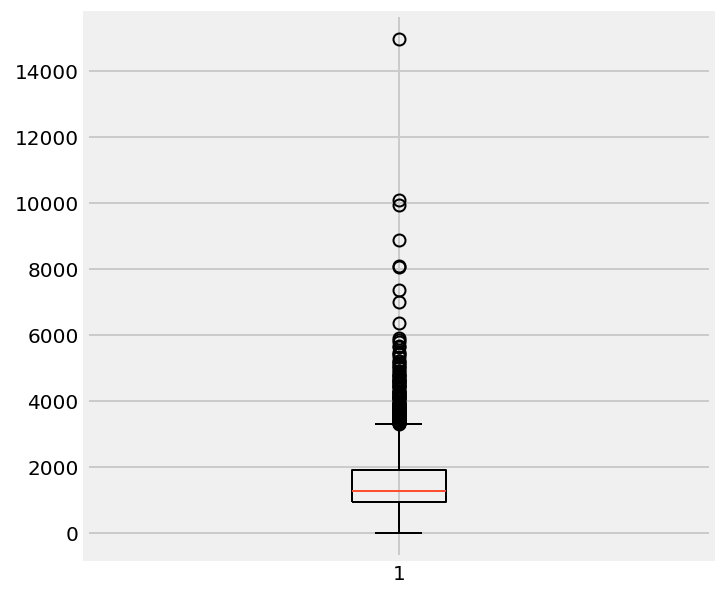

In [22]:
# Boxplot de 'Long_Critica_Normalizada'
plt.style.use('fivethirtyeight')
 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
 
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(resumen['Long_Critica_Normalizada'])
plt.show()

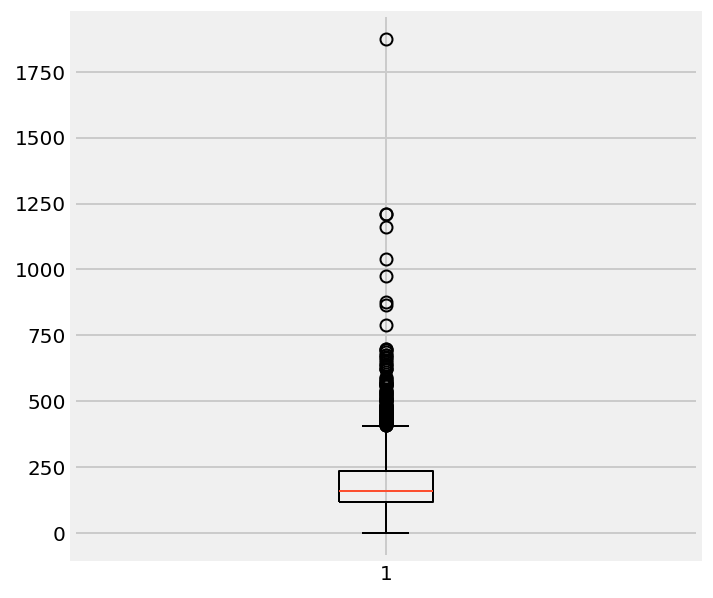

In [23]:
# Boxplot de 'Palabras_Critica_Normalizada'
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(resumen['Palabras_Critica_Normalizada'])
plt.show()

Vemos que hay algunos outliers: Criticas muy extensas... pero al ser texto que aporta información nos quedamos con todas ellas.

## **Extracción de características *sparse* con `scikit-learn`**
Vamos a calculas las matrices de características *Bag-of-Words* y *Tf-Idf* del conjunto de textos anterior.\
Vamos a usar la librería `scikit-learn` para vectorizar los documentos.

Concretamente, se generarán estas matrices de características para el conjunto de las críticas. 
- Matriz BoW simple (**Se ha probado también a generarlo con bigramas y con bigramas y trigramas pero no han dado mejor resultado**).
- Matriz TF-IDF (**Se han probado configuracion por defecto [mínimo de 1 y máximo de 1 documentos] y eliminando las palabras menos frecuentes y las más frecuentes [mínimo de 2 y máximo de 5 documentos] funcionando mejor la configuración por defecto**)
  - Cuáles son las palabras más frecuentes eliminadas.

Se podría usar el DataFrame ya generado (columna `Critica_Normalizada`) directamente para la generacion de los conjuntos BoW y TF-IDF, lo que implicaría usar el dataset cargado en memoria, pero como se ha querido usar el **enfoque *streaming* con generadores, vamos a hacer lo mismo para la generacion de los mismos**. Dejaremos este DataFrame para el analisis EDA previo y la generación del CSV de back-up.

Como hemos detectado que hay una critica vacia la pasaremos con next en nuestro generador si la l

Para seguir con el ejercicio, utilizamos la funcion `generaCritica` vista en clase **con la modificación de incluir el criterio de imputación de criticas vacías o incompletas**.

In [192]:
# Como queremos seguir el enfoque Streaming 
# Tuplas de parse_folder: (titulo, rtxt (resumen de la critica), btxt (critica), rank (1-5))
def generaCritica(criticas):
    """Función de tipo generator que devuelve el
    texto normalizado de cada crítica.
    Entrada:
    criticas: objeto 'parse_folder' que itera
    sobre el directio de las críticas
    Salida:
    texto normalizado de cada crítica"""
    for c in criticas:
        # 
        # Usamos mejor el criterio de usar el resumen si este es mayor que la crítica,
        if len(c[1]) > len(c[2]):
          yield normaliza(c[1], lemas=True)
        # Y para los casos en los que ambas esten vacías se eliminarían
        elif len(c[2]) == 0:
          continue   # Saltamos la(s) vacía(s)
        else:
          yield normaliza(c[2], lemas=True)

### **Generación de la matriz de características BoW**
Se generará la matriz BoW con unigramas, bigramas y trigramas.





In [25]:
# CountVectorizer acepta como entrada cualquier objeto iterable que devuelva x cada iteracion un str
#vect_BoW = CountVectorizer(ngram_range=(1,2))#Con Exactitud:  0.45
#vect_BoW = CountVectorizer(ngram_range=(1,3))#Con Exactitud:  0.43
vect_BoW = CountVectorizer()                  #Con Exactitud:  0.59

criticas = generaCritica(parse_folder(path))
# fit_transform aprende y transforma el vocabulario
BoW_criticas = vect_BoW.fit_transform(criticas) 

# num_criticas * long_vocab
BoW_criticas

<2714x38035 sparse matrix of type '<class 'numpy.int64'>'
	with 414040 stored elements in Compressed Sparse Row format>

### **Generación de la matriz de características Tf-Idf**
Matriz TF-IDF eliminando las palabras menos frecuentes y las más frecuentes (mínimo de 2 y máximo de 5 documentos) y (mínimo de 1 y máximo de 1 documentos, por defecto).




In [26]:
# Matriz TF-IDF eliminando las palabras menos frecuentes y las más frecuentes (mínimo de 2 y máximo de 5 documentos)
# En este caso la dimension se reduce porque no consideran palabras segun num de ocurrencias
#vect_TfIdf = TfidfVectorizer(min_df=2, max_df=5) #Con Exactitud:  0.41

# Matriz TF-IDF, valores por defecto (min_df=1, max_df=1.0)
vect_TfIdf = TfidfVectorizer() #Con Exactitud:  0.48

criticas = generaCritica(parse_folder(path))
# fit_transform aprende y transforma el vocab
TfIdf_criticas = vect_TfIdf.fit_transform(criticas) 

TfIdf_criticas

<2714x38035 sparse matrix of type '<class 'numpy.float64'>'
	with 414040 stored elements in Compressed Sparse Row format>

### **Generación del conjunto de test**

In [193]:
# Test folder
test_path = '/content/criticas/test'

In [28]:
# Creamos una lista en blanco
datos_test = []

# Recorremos las críticas y generamos el dataset de test
# Tuplas de parse_folder: (titulo, rtxt (resumen de la critica), btxt (critica), rank (1-5))
for c in parse_folder(test_path):
  cNorm = normaliza(c[2], lemas=True)

  datos_test.append({
      'Titulo': c[0],
      'Critica': c[2],
      'Long_Critica_Normalizada': len(cNorm),
      'Critica_Normalizada': cNorm,
      'Valoracion': c[4]
  })

resumen_test = pd.DataFrame(datos_test)

In [194]:
# Comprobamos si hay alguna critica vacia tras normalizar
resumen_test.loc[resumen_test['Long_Critica_Normalizada'] == 0]

,Titulo,Critica,Long_Critica_Normalizada,Critica_Normalizada,Valoracion


In [196]:
# Vemos si tienen sentido las longitudes mínimas: parece que si
resumen_test.sort_values('Long_Critica_Normalizada').head(1)

,Titulo,Critica,Long_Critica_Normalizada,Critica_Normalizada,Valoracion
785,El ilusionista,"Cinta cuyos únicos puntos positivos son Paul Giamatti (grande como siempre, el resto como si pasasen por ahí.) y el aspecto técnico, a la altura de las circunstancias.La dirección falla estrepitosamente hasta tal punto que la historia queda borrosamente esbozada en pantalla; uno no logra saber qué es lo que intentan contarnos hasta bien entrada la hora y cuarto de duración. Y su guión, tramposo hasta más no poder, no ayuda en absoluto.Bastante decepcionante, aunque se deja ver y, al menos, dentro de lo que cabe, es entretenidilla y las secuencias ""mágicas"" son bastante atractivas para la vista.",331,cinta cuyo único punto positivo persona grande resto pasar aspecto técnico altura circunstancia dirección fallo estrepitosamente punto historia quedar borrosamente esbozado pantalla lograr contarno entrado hora cuarto duración guión tramposo ayudar absoluto decepcionante dejar caber entretenidilla secuencia mágico atractivo vista,MALA


In [198]:
X_test = resumen_test['Critica_Normalizada']
y_test = resumen_test['Valoracion']

In [197]:
# Numero de ejemplos de test correcto
len(resumen_test)

1164

### **Generación de modelos** 
Funciones auxiliares para validación:

In [199]:
# Funcion para plotear las curvas ROC y mostrar el AUC para cada clase
def plot_auc(y_test, y_pred_proba, label_list, title):
  '''
    y_test: etiquetas reales
    y_pred_proba: predicciones
  '''
  colors = ["green", "red", "orange"]
  classes = {v: k for v, k in enumerate(label_list)}

  fig, ax1 = plt.subplots(1,figsize=(10, 5))
   
  for c in classes:
    clase_positiva = c
    label = classes[clase_positiva]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,labels.index(label)], pos_label=label)
    ax1.plot(fpr, tpr, 'r-.', label = classes[c]+'(%2.2f)' % auc(fpr, tpr), color=colors[c])

  ax1.set_xlabel('False Positive Rate')
  ax1.set_ylabel('True Positive Rate')
  ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
  ax1.set_title(title)
  ax1.legend();

In [34]:
#definimos una función para entrenar y validar cada clasificador
def train_predict_evaluate_model(classifier, 
                                 train_features, train_labels, 
                                 test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    # evaluate model prediction performance   
    print(classification_report(test_labels, predictions))
    return predictions 

# creamos los modelos para
modelos = [('Logistic Regression', LogisticRegression(solver='liblinear')),
               ('Naïve Bayes', MultinomialNB()),
               ('Linear SVM', SGDClassifier(loss='hinge', max_iter=10000, tol=1e-5)),
               ('RBF SVM', SVC(gamma='scale', C=2))]

#### **Modelos con una matriz sparse (BoW o TF-IDF) + clasificador**
Se probarán dos modelos cada uno de ellos con un tipo de matriz sparse diferente.
- Bow (unigramas) + NaiveBayes (Se han probado: solo unigramas, unigramas y bigramas y unigramas, bigramas y trigramas).
- TF-IDF + NaiveBayes (Se han probado vectorizaciones sin especificar límites de ocurrencias, y eliminando las palabras menos frecuentes y las más frecuentes [mínimo de 2 y máximo de 5 documentos], funcionando mejor a llamar al vectorizador sin argumentos [mínimo de 1 y máximo de 1 documentos]).


##### **Seleccion de clasificador para Bow**

Para ver el rendimiento del modelo usamos el conjunto de test. Primero transformamos el conjunto de test a su matriz BoW mediante el vectorizador aprendido en TRAIN y aplicamos el modelo entrenado:

In [35]:
# Se usaran como entradas
X_train_vectorized_BoW = BoW_criticas
X_train_vectorized_BoW

<2714x38035 sparse matrix of type '<class 'numpy.int64'>'
	with 414040 stored elements in Compressed Sparse Row format>

Verificación del modelo:



In [36]:
# Predecimos sobre el conjunto de test
# vectorizamos  para generar la BoW en el clasificador
X_test_vectorized_BoW = vect_BoW.transform(X_test)
X_test_vectorized_BoW

<1164x38035 sparse matrix of type '<class 'numpy.int64'>'
	with 176002 stored elements in Compressed Sparse Row format>

In [200]:
y_train = resumen['Valoracion']

In [38]:
#entrenamos clasificadores con modelos BoW
for m, clf in modelos:
    print('Modelo {} con características BoW'.format(m))
    BoW_predictions = train_predict_evaluate_model(classifier=clf,
                                           train_features=X_train_vectorized_BoW,
                                           train_labels=y_train,
                                           test_features=X_test_vectorized_BoW,
                                           test_labels=y_test)

Modelo Logistic Regression con características BoW
              precision    recall  f1-score   support

       BUENA       0.63      0.64      0.63       395
        MALA       0.66      0.66      0.66       395
     REGULAR       0.47      0.46      0.46       374

    accuracy                           0.59      1164
   macro avg       0.58      0.58      0.58      1164
weighted avg       0.59      0.59      0.59      1164

Modelo Naïve Bayes con características BoW
              precision    recall  f1-score   support

       BUENA       0.55      0.79      0.65       395
        MALA       0.73      0.58      0.65       395
     REGULAR       0.51      0.39      0.44       374

    accuracy                           0.59      1164
   macro avg       0.60      0.58      0.58      1164
weighted avg       0.60      0.59      0.58      1164

Modelo Linear SVM con características BoW
              precision    recall  f1-score   support

       BUENA       0.59      0.67      0.62    

Seleccionamos Naïve Bayes

##### **Bow + NaiveBayes**
Se han probado 3 vectorizaciones BoW: solo unigramas, unigramas y bigramas y unigramas, bigramas y trigramas. 
**El que mejor ha resultado es el que usa solo unigramas.**


Entrenamiento del modelo:

In [39]:
#Entrenamos el modelo con el conjunto de train
from sklearn.model_selection import GridSearchCV

modelNB_BoW = MultinomialNB()
param_grid = {'alpha': [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0],
              'class_prior': [None, class_weights],
              'fit_prior': [True, False]}

#Entrenamos el modelo con el conjunto de train por GridSearch y nos quedamos con el mejor
modelNB_BoW = MultinomialNB()
cv = GridSearchCV(modelNB_BoW, param_grid, scoring="accuracy", cv=5, n_jobs=-1)

cv.fit(X_train_vectorized_BoW, y_train)
cv.cv_results_
modelNB_BoW = cv.best_estimator_

In [40]:
modelNB_BoW

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

In [41]:
prediccion = modelNB_BoW.predict(X_test_vectorized_BoW)

#5 primeras preds
prediccion[:5]

array(['MALA', 'MALA', 'MALA', 'MALA', 'REGULAR'], dtype='<U7')

In [42]:
# Comprobamos numero predicciones
prediccion.shape

(1164,)

Vemos el resultado de la predicción y calculamos su precisión con distintas métricas.  
Ejemplo de predicción de algunas muestras:

In [43]:
pd.DataFrame({
    'Texto':X_test,
    'Valoracion':y_test,
    'Predicción':prediccion
}).sample(5)

,Texto,Valoracion,Predicción
883,gracia querejeta directora tomado medida conocimiento obra ldquo;cuar vuelva ladordquo año recordar gustar ver ldquo;el viaje persona ldquo;héctorrdquo pese pinta priori acudí cine ldquo;siete mesa billar francésrdquo ir encontrar llevado vibración película encontrar finalmente película deber marcar referencia camino posible transitar cine español decir evidente público demandar cine género español amplio presupuesto propuesta gracia querejeta cabida cartelera necesario ldquo;siete mesa billar francésrdquo guión obra directora persona capaz crear personaje carne hueso sentir puñado estupendo actor capaz dar él vida película falta director solvente proyecto éxito taquilla siglo xxi falta cosa campaña marketing fallar seguramente falta presupuesto holgado decir guión construcción personaje rabia error acabar comprender resolución historia tuerto persona consecuente visto resto film improvisado sensación reducir duración fim alargar historia persona impecable persona pese previsibilidad resolución pequeño pega guión ejemplar actuación pegar blanca persona ganar premio festival cine san sebastián interpretación femenino haber él ganar persona haber injusticia increíble lucha persona realmente durar año resto secundario igualmente soberbio película niño víctor valdivia promesa cine español actúar destacar alguien tomar él desprecio gustar mencionar persona año robar escena compañero reparto mérito atribuir él directora planificar escena aprovechar máximo talento actor calmado transparente puesto escena demostración confianza actor regalo espectador añadir presupuesto cine españa valoración moonfleet,BUENA,REGULAR
154,monster house suscribir línea cinta animación estrenado llevar año exagerar calificar pionera asunción patrón estético temático género terror empleado animación monster house cinta apto público venir clase rodado cine terror tratar dejar binomio aventuras-humor habitual animación año monster house guiño continuo referente cinematográfico género miedo casa encantado miedo vecino misterioso sospechoso ocultar secreto terrorífico recordar disparatado matarás vecino persona llamada anónimo amenazador teléfono concurrencia extraño suceso halloween aspecto ambientación movimiento cámara deudor cine distinto animación puesto buscar paralelismo tripleta investigador formado preadolescent recordar entrañabl goonies perfil distinto personaje valiente cualificado investigador persona amigo regordete gracioso partidario ejercer héroe cambio arriesgar pellejo jenny chica suspirir poner sensatez grupo caracterización persona viejo encorvado rostro enjuto temible vestido harapiento ropaj resultar familiar punto cómico explotar pintoresco secundario friki-pizzero skull veinteañero especialista videojuego cómics acudir compañía solicitar él consejo canguro persona novio persona pareja despistado poli tratamiento gráfico monster house demostrar animación digital quedar margen seguir sorprender filme margen magnífico tratamiento textura cinta sobresalir ágil movimiento cámara cuidado atmósfero perfecto introducir yo propuesta misterio principal virtud cinta dirigido debutante persona apadrinado zorro persona persona errar tiro polard express radicar magnífico inteligente guión reparo historia aventura miedo capaz resultar divertido niño adulto acudir estereotipo visto ciento cinta terror historia ocultar monstruoso casa original predecible querer descubrir él acompañen compañía singular aventura diversión garantizado,BUENA,BUENA
210,pareja detective aficionado sacado misterioso asesinato manhattan aparición fantástico parca corifeo poderosa afrodita personaje atolondrado persona papel atolondrado persona tanto personaje persona antihéroe interpretar heroína persona luchar malo apocamiento protagonista hipocondríaco robar medalla allen cajón sastre interminable sacar mil cine invención transcripción vida privado opción entretenida viendo meter chica llegar conclusión persona ególatrar musa persona aprendiz

Exactitud del modelo
(Núm. predicciones correctas / Total de muestras)

In [44]:
from sklearn.metrics import accuracy_score

# Exactitud (accuracy) <> Precisón  
print('Exactitud: ', accuracy_score(y_test, prediccion))

Exactitud:  0.5893470790378007


Matriz de confusión (predicción -columnas- frente a etiquetas reales -filas-)

In [45]:
# Chequeamos el orden de las etiquetas en el modelo
labels = list(modelNB_BoW.classes_)
labels

['BUENA', 'MALA', 'REGULAR']

In [46]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_test, prediccion)
pd.DataFrame(cm, index=('BUENA_true','MALA_true', 'REGULAR_true'), columns=('BUENA_true','MALA_true', 'REGULAR_true'))
#filas: True, columnas: Prediction

,BUENA_true,MALA_true,REGULAR_true
BUENA_true,312,28,55
MALA_true,82,229,84
REGULAR_true,173,56,145


Podemos ver un informe más completo del clasificador con la métrica `classification_report`:

In [47]:
from sklearn.metrics import classification_report

print(classification_report(y_test, prediccion))

              precision    recall  f1-score   support

       BUENA       0.55      0.79      0.65       395
        MALA       0.73      0.58      0.65       395
     REGULAR       0.51      0.39      0.44       374

    accuracy                           0.59      1164
   macro avg       0.60      0.59      0.58      1164
weighted avg       0.60      0.59      0.58      1164



Área bajo la curva ROC:  
Para calcular el área bajo la curva ROC (AUC) es necesario obtener la probabilidad de salida del clasificador con `predict_proba`

In [48]:
prediccion_prob = modelNB_BoW.predict_proba(vect_BoW.transform(X_test))

# Etiqueta: 'BUENA'
#la primera columna corresponde a la etiqueta 'BUENA'
#Es necesario convertir los True Labels a un array lógico (1 para etiqueta REGULAR)
roc_auc_score((y_test=='BUENA'), prediccion_prob[:,labels.index('BUENA')], multi_class='ovr')

0.7971342035522049

In [49]:
# Etiqueta: 'MALA'
#la segunda columna corresponde a la etiqueta 'MALA'

#Es necesario convertir los True Labels a un array lógico (1 para etiqueta MALA)
roc_auc_score((y_test=='MALA'), prediccion_prob[:,labels.index('MALA')], multi_class='ovr')

0.8410067323994666

In [50]:
# Etiqueta: 'REGULAR'
#Es necesario convertir los True Labels a un array lógico (1 para etiqueta REGULAR)
roc_auc_score((y_test=='REGULAR'), prediccion_prob[:,labels.index('REGULAR')], multi_class='ovr')

0.6509747512353619

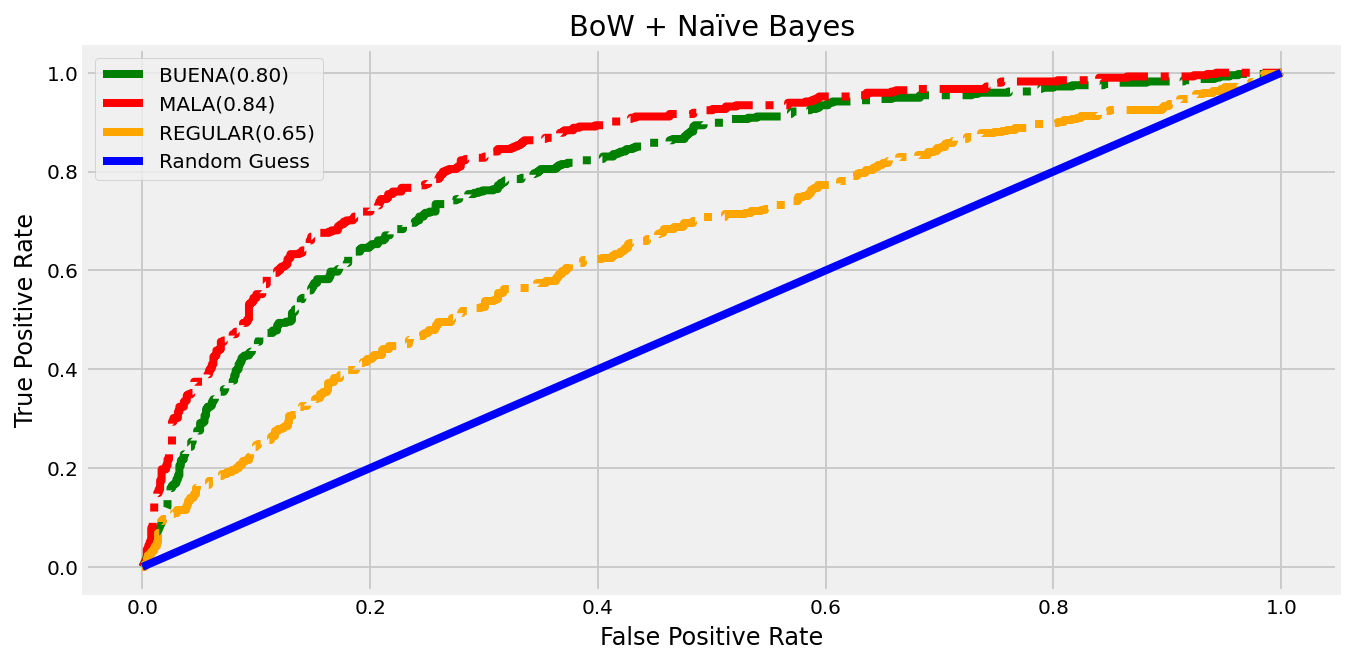

In [51]:
# Curvas ROC
plot_auc(y_test, prediccion_prob, labels, "BoW + Naïve Bayes")

##### **Seleccion de clasificador para TF-IDF**
Para ver el rendimiento del modelo usamos el conjunto de test. Primero transformamos el conjunto de test a su matriz TF-IDF mediante el vectorizador aprendido en TRAIN y aplicamos el modelo entrenado:

In [52]:
# Se usaran como entradas
X_train_vectorized_TfIdf = TfIdf_criticas
X_train_vectorized_TfIdf

<2714x38035 sparse matrix of type '<class 'numpy.float64'>'
	with 414040 stored elements in Compressed Sparse Row format>

Verificación del modelo:



In [53]:
# Predecimos sobre el conjunto de test
# vectorizamos  para generar la BoW en el clasificador
X_test_vectorized_TfIdf = vect_TfIdf.transform(X_test)
X_test_vectorized_TfIdf

<1164x38035 sparse matrix of type '<class 'numpy.float64'>'
	with 176002 stored elements in Compressed Sparse Row format>

In [54]:
#entrenamos clasificadores con modelos TfIdf
for m, clf in modelos:
    print('Modelo {} con características TfIdf'.format(m))
    BoW_predictions = train_predict_evaluate_model(classifier=clf,
                                           train_features=X_train_vectorized_TfIdf,
                                           train_labels=y_train,
                                           test_features=X_test_vectorized_TfIdf,
                                           test_labels=y_test)

Modelo Logistic Regression con características TfIdf
              precision    recall  f1-score   support

       BUENA       0.58      0.77      0.66       395
        MALA       0.70      0.68      0.69       395
     REGULAR       0.52      0.35      0.42       374

    accuracy                           0.61      1164
   macro avg       0.60      0.60      0.59      1164
weighted avg       0.60      0.61      0.59      1164

Modelo Naïve Bayes con características TfIdf
              precision    recall  f1-score   support

       BUENA       0.41      0.96      0.58       395
        MALA       0.81      0.38      0.52       395
     REGULAR       0.53      0.09      0.16       374

    accuracy                           0.48      1164
   macro avg       0.59      0.48      0.42      1164
weighted avg       0.59      0.48      0.42      1164

Modelo Linear SVM con características TfIdf
              precision    recall  f1-score   support

       BUENA       0.62      0.70      0.

Seleccionamos Naïve Bayes por su simplicidad, aunque se probará tambien la Support Vector Machine con funciones de base radial (RBF SVM) para ver si merece la pena.

##### **TF-IDF + NaïveBayes**
Se han probado 2 variantes de vectorización, sin especificar límites y eliminando las palabras menos frecuentes y las más frecuentes (mínimo de 2 y máximo de 5 documentos) dando mejor resultados sin establecer mínimo/máximo de ocurrencias.

Entrenamiento del modelo:

In [55]:
#Entrenamos el modelo con el conjunto de train
from sklearn.model_selection import GridSearchCV

modelNB_TfIdf = MultinomialNB()
param_grid = {'alpha': [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0],
              'class_prior': [None, class_weights],
              'fit_prior': [True, False]}

#Entrenamos el modelo con el conjunto de train por GridSearch y nos quedamos con el mejor
modelNB_TfIdf = MultinomialNB()
cv = GridSearchCV(modelNB_TfIdf, param_grid, scoring="accuracy", cv=5, n_jobs=-1)

cv.fit(X_train_vectorized_TfIdf, y_train)
cv.cv_results_
cv.best_estimator_

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=False)

In [56]:
modelNB_TfIdf = cv.best_estimator_.fit(X_train_vectorized_TfIdf, y_train)

In [57]:
prediccion = modelNB_TfIdf.predict(X_test_vectorized_TfIdf)

#5 primeras preds
prediccion[:5]

array(['MALA', 'MALA', 'MALA', 'MALA', 'REGULAR'], dtype='<U7')

In [58]:
prediccion.shape

(1164,)

Vemos el resultado de la predicción y calculamos su precisión con distintas métricas.  
Ejemplo de predicción de algunas muestras:

In [59]:
pd.DataFrame({
    'Texto':X_test,
    'Valoracion':y_test,
    'Predicción':prediccion
}).sample(5)

,Texto,Valoracion,Predicción
1088,pronóstico persona convertir artesano quedar decir pronóstico persona película perfecto diez año sly parecer peligro extinción paisano gener-acción rocky balboa emotivo homenaje personaje querido cine vuelta boxeador llevar sorpresa gordo grande regreso personaje clásico oscuro john rambo cuarto aventura noventa minuto volver cine peli rodar dejar pañal decepcionante cuarto aventura viejo john mcclane rambo encerrado interior ajeno mierda habitar mundo rescatar grupo voluntario viajar birmania colaborar misión humanitario jungla perder seña identidad saga clásico superior persona rambo director protagonista guionista puñetazo mesa grito pulmón mancharno sangre dejar gusto película tanto sangre episodio violento violación tortura matanza veíar frikada cannon envidiable pulso narrativo medianía colosal dejar recuerdo colosal clímax ejercicio nostalgia estilo tomar él broma rambo volver,BUENA,REGULAR
671,harry potter deprimido guionista impresión obtuve harry potter orden fénix quinto entrega cinematográfico personaje creado escritora literatura infantil estrenar mañana pantalla español persona regresar tiniebla potter -por utilizar magia escuela hogwarts magia hechicería defensa odioso primo dudley- castigar expulsión centro malo rollo instalar cabeza muerte compañero estudio recuerdo padre asesinado sed venganza desprecio personal sometido director hogwarts haber él readmitir academia hacer convertir triste gris solitario persona director enfrentar universo potter compañía pesarós amparar él abatimiento marcar harry potter película aparte poseer ritmo alarmantemente lento resultar confuso narrado pasaje falta consistencia guión ver dotado número personaje desarrollado innecesario ocurrir fantasmagórico presencia persona dar vida tentadora malvado persona metido presión historia único intención contar famosillo brillantez lujoso crédito marketing taquilla decir harry potter orden fénix costar muchísimo arrancar quedar medias tinta teórico tensión acumular metraje explosionar veinte minuto proyección innegable cinta adquirir calibre vibrante interesante remontar pesadez narrativo ir desarrollar él situación acción ofrecer punto culminante seguir oscuro fuerza positivo capítulo localizar intención romper clásico esquema argumental definido título anterior cinta iniciar finalizar ciudad subsuelo londres dar él protagonismo familiar recinto escuela hogwarts desarrollar central pesarós prólogo espléndido prometedor filmado aire libre tono cercano cine persona maravilloso visual escena interior gigantesca ensombrecido estancia plagado estantería lleno bola cristal delirante presencia inmejorable persona rol patético mujer ansia dictatorial remarcable denotar cansancio serie faltar capítulo harry potter perder sentido humor arte mágico enganchar millón espectador edad animar chico marcha forzado base prozac similar visita psiquiatra ir alguien sacar él pozo hundir seguro logre ganar cara título,REGULAR,REGULAR
240,imaginar gestar año good year persona acabar salir fracaso taquillero reino cielos punto embarcar él proyecto ambicioso american gangster película sencillito barato rodaje rápido género gocir fervor popular finalmente rodar comedia dramático corte presuntamente romántico protagonista atractivo carismático persona mujer cuerpo imponente plumero persona paisaje bonito moto chular prota mover homenaje película hermano pizca filosofía barato montón diálogo ridículo medida guión ser estaríar auténtico espanto película história típico colmo lleno tópico vida amor dinero diferenciar guión película temática similar destinado adolescente dirigir persona consecuencia película dirigido corrección ritmo entretenidillo acción avanzar tronpicón tópico tópico película hacer excesivamente larga notar persona director culto dejar engañar ver calidad tratar él director obra maestro alien blade runner película haber recibir palo crítica brutal motivo faltar,MALA,MALA
305,película mito época pasado invocar devol

Exactitud del modelo
(Núm. predicciones correctas / Total de muestras)

In [60]:
from sklearn.metrics import accuracy_score

# Exactitud (accuracy) <> Precisón  
print('Exactitud: ', accuracy_score(y_test, prediccion))

Exactitud:  0.5781786941580757


Matriz de confusión (predicción -columnas- frente a etiquetas reales -filas-)

In [61]:
# Chequeamos el orden de las etiquetas en el modelo
labels = list(modelNB_TfIdf.classes_)
labels

['BUENA', 'MALA', 'REGULAR']

In [62]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_test, prediccion)
pd.DataFrame(cm, index=('BUENA_true','MALA_true', 'REGULAR_true'), columns=('BUENA_true','MALA_true', 'REGULAR_true'))
#filas: True, columnas: Prediction

,BUENA_true,MALA_true,REGULAR_true
BUENA_true,298,31,66
MALA_true,70,227,98
REGULAR_true,160,66,148


Podemos ver un informe más completo del clasificador con la métrica `classification_report`:

In [63]:
from sklearn.metrics import classification_report

print(classification_report(y_test, prediccion))

              precision    recall  f1-score   support

       BUENA       0.56      0.75      0.65       395
        MALA       0.70      0.57      0.63       395
     REGULAR       0.47      0.40      0.43       374

    accuracy                           0.58      1164
   macro avg       0.58      0.57      0.57      1164
weighted avg       0.58      0.58      0.57      1164



Área bajo la curva ROC:  
Para calcular el área bajo la curva ROC (AUC) es necesario obtener la probabilidad de salida del clasificador con `predict_proba`

In [64]:
prediccion_prob = modelNB_TfIdf.predict_proba(vect_TfIdf.transform(X_test))

# Etiqueta: 'BUENA'
#la primera columna corresponde a la etiqueta 'BUENA'
#Es necesario convertir los True Labels a un array lógico (1 para etiqueta REGULAR)
roc_auc_score((y_test=='BUENA'), prediccion_prob[:,labels.index('BUENA')], multi_class='ovr')

0.8046353146450264

In [65]:
# Etiqueta: 'MALA'
#la segunda columna corresponde a la etiqueta 'MALA'

#Es necesario convertir los True Labels a un array lógico (1 para etiqueta MALA)
roc_auc_score((y_test=='MALA'), prediccion_prob[:,labels.index('MALA')], multi_class='ovr')

0.8436075126335368

In [66]:
# Etiqueta: 'REGULAR'
#Es necesario convertir los True Labels a un array lógico (1 para etiqueta REGULAR)
roc_auc_score((y_test=='REGULAR'), prediccion_prob[:,labels.index('REGULAR')], multi_class='ovr')

0.6715866783997835

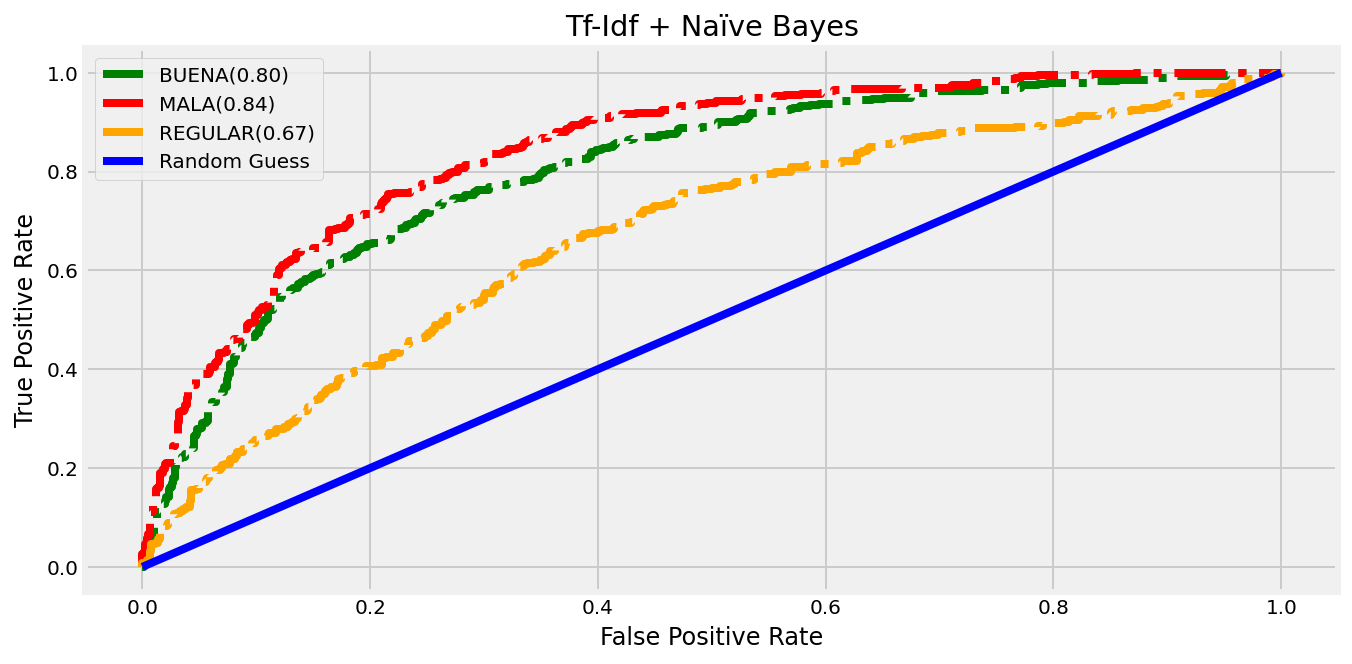

In [67]:
# Curvas ROC
plot_auc(y_test, prediccion_prob, labels, "Tf-Idf + Naïve Bayes")

##### **TF-IDF + RBF SVM**
Como este clasificador parece que podría ser levemente mejor, vamos a tratar de optimizarlo con GridSearch para ver si merece la pena ese incremento en complejidad respecto de Naïve Bayes.

Entrenamiento del modelo:

In [68]:
#Probar SVC (Support Vector Clasifier)
param_grid = {'C': [2.0, 1.0],
              'degree':[2, 3],
              'tol': [0.001, 0.0001],
              'probability': [True]} # Para sacar predict_proba para las ROC

modelSVC_TfIdf = SVC()
cv = GridSearchCV(modelSVC_TfIdf, param_grid, cv=5, n_jobs=-1)

#Entrenamos el modelo con el conjunto de train por GridSearch y nos quedamos con el mejor
cv.fit(X_train_vectorized_TfIdf, y_train)
cv.cv_results_
modelSVC_TfIdf = cv.best_estimator_

In [69]:
modelSVC_TfIdf

SVC(C=2.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [70]:
modelSVC_TfIdf = cv.best_estimator_.fit(X_train_vectorized_TfIdf, y_train)

In [71]:
prediccion = modelSVC_TfIdf.predict(X_test_vectorized_TfIdf)

#5 primeras preds
prediccion[:5]

array(['MALA', 'MALA', 'REGULAR', 'REGULAR', 'REGULAR'], dtype=object)

In [72]:
prediccion.shape

(1164,)

Vemos el resultado de la predicción y calculamos su precisión con distintas métricas.  
Ejemplo de predicción de algunas muestras:

In [73]:
pd.DataFrame({
    'Texto':X_test,
    'Valoracion':y_test,
    'Predicción':prediccion
}).sample(5)

,Texto,Valoracion,Predicción
489,altura mundo batalla persa espartano transcurrir termópilas fielmente basado cómic persona información objetivo recogido decena webs blogs revista periódico variado vayar subjetivo subjetivo parecer peliculón poner cien subir pulsación soltar chut adrenalina revolucionar endorfina encantar fascinar impactar película perfecto obra maestro cine pedir falla personaje persona cómic impresionante señorial todopoderoso enigmático mitad persona mitad dios conseguido película persona reinona divina muerte lastrar efecto grandiosidad tebeo monstruo grotesco llegar cansar elefante matarile celeridad película colosal identificar historia espartano directamente pedíar película espectáculo hablar fidelidad fotograma gráfico persona persona inspirar realidad realidad alcance paso termópilas cuadro clásico persona añadir iconografía cristiano san sebastián aseteado persona pasar noche huerto persona persona vender maestro treinta moneda plata persona filmar película aprovechar imaginería clásico persona acuchillado espíritu película bélico diálogo efectista mitológico frase contundente lucha sombra secuencia barco arribar costa ver troya cartas iwo jima poder hablar tema oriente occidente protesta irán tratamiento persa mirar paso salir maravillado espectáculo asistir hablar realidad apetecer absolutamente espectáculo sangre violencia homber llamado irritar diverso colectivo hipnotizar completo releer tebeo seguramente volver película bolunto compro espada escudo espartano colgarlo pared casa merecer persona película,BUENA,BUENA
663,actualidad número comedia hollywood año cuarenta cincuenta resultar realmente entrañabl ingenuidad caracterizar mayoría caso ingenuidad formar campaña publicidad mostrar sueño americano atisbo sordidez corrupción vicio exponente persona suspiros corazón persona retomar intencionadamente camino marcar clásico fábula moderno utópico persona persona joven prometedor empresario punto cerrar negocio vida trastocar completamente predicción horóscopo cumplir acudir vecino persona busca consejo finalmente persona buscar desesperadamente editorial revista horóscopo cerrar contrato persona plantear película homenaje revista fotonovela publicación idilio realmente existir aires año cincuenta persona suspiros corazón arranque prometedor historia perder fuelle abundante cine idea inicial saber desarrollar plasmar film persona ir mano ingenuidad terminar convertir cinta pastel empalagoso apto diabético altibajo ritmo escena llegar provocar vergüenza ajeno enfrentamiento viejo combatiente exiliado italiano español interpretación correcto destacar desgraciadamente motivo persona forzado debutante persona soltura realizar interpretación natural fresco suspiros corazón premisa desgraciadamente saber plasmar desarrollar adecuadamente película haciéndola previsible ligeramente aburrido,MALA,MALA
531,"película irregular persona presentar mezcla mundo real literario interesante colocar propuesta cinematográfico destacable abanico director persona actor encantar volver demostrar vena cómico falta excelente papel show truman olvidate mí""o the majestic número encarnar doble personaje alternar vida cotidiano detective protagonista libro comenzar leer extraño conexión encontrar persona encandilar copa candyman acérrimo género fantástico terror interpretar mujer persona punto destacar fotografía persona presentar atmósfera momento real narrado novela dotar estética comic recordar city guión complejo momento hacer espectador estar entregar completamente película recaer edulcoramiento público moralina haber él evitar dejar gracia satisfacer espectador número casualidad juego guionista persona cifra conformar laberinto misterio circunstancia traer cabeza persona definitiva número presentar película destacable punto interesante intérprete dosis cine hacer delicia amante suspense thriller persona",REGULAR,REGULAR
155,escuché leer persona rodar escena acción verosímil echar vistazo heat persona cinta equiparable 

Exactitud del modelo
(Núm. predicciones correctas / Total de muestras)

In [74]:
from sklearn.metrics import accuracy_score

# Exactitud (accuracy) <> Precisón  
print('Exactitud: ', accuracy_score(y_test, prediccion))

Exactitud:  0.6099656357388317


Matriz de confusión (predicción -columnas- frente a etiquetas reales -filas-)

In [75]:
# Chequeamos el orden de las etiquetas en el modelo
labels = list(modelSVC_TfIdf.classes_)
labels

['BUENA', 'MALA', 'REGULAR']

In [76]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_test, prediccion)
pd.DataFrame(cm, index=('BUENA_true','MALA_true', 'REGULAR_true'), columns=('BUENA_true','MALA_true', 'REGULAR_true'))
#filas: True, columnas: Prediction

,BUENA_true,MALA_true,REGULAR_true
BUENA_true,284,29,82
MALA_true,59,253,83
REGULAR_true,126,75,173


Podemos ver un informe más completo del clasificador con la métrica `classification_report`:

In [77]:
from sklearn.metrics import classification_report

print(classification_report(y_test, prediccion))

              precision    recall  f1-score   support

       BUENA       0.61      0.72      0.66       395
        MALA       0.71      0.64      0.67       395
     REGULAR       0.51      0.46      0.49       374

    accuracy                           0.61      1164
   macro avg       0.61      0.61      0.61      1164
weighted avg       0.61      0.61      0.61      1164



Área bajo la curva ROC:  
Para calcular el área bajo la curva ROC (AUC) es necesario obtener la probabilidad de salida del clasificador con `predict_proba`

In [78]:
prediccion_prob = modelSVC_TfIdf.predict_proba(vect_TfIdf.transform(X_test))

# Etiqueta: 'BUENA'
#la primera columna corresponde a la etiqueta 'BUENA'
#Es necesario convertir los True Labels a un array lógico (1 para etiqueta REGULAR)
roc_auc_score((y_test=='BUENA'), prediccion_prob[:,labels.index('BUENA')], multi_class='ovr')

0.8388833105627891

In [79]:
# Etiqueta: 'MALA'
#la segunda columna corresponde a la etiqueta 'MALA'

#Es necesario convertir los True Labels a un array lógico (1 para etiqueta MALA)
roc_auc_score((y_test=='MALA'), prediccion_prob[:,labels.index('MALA')], multi_class='ovr')

0.8660960313410478

In [80]:
# Etiqueta: 'REGULAR'
#Es necesario convertir los True Labels a un array lógico (1 para etiqueta REGULAR)
roc_auc_score((y_test=='REGULAR'), prediccion_prob[:,labels.index('REGULAR')], multi_class='ovr')

0.7007818317200297

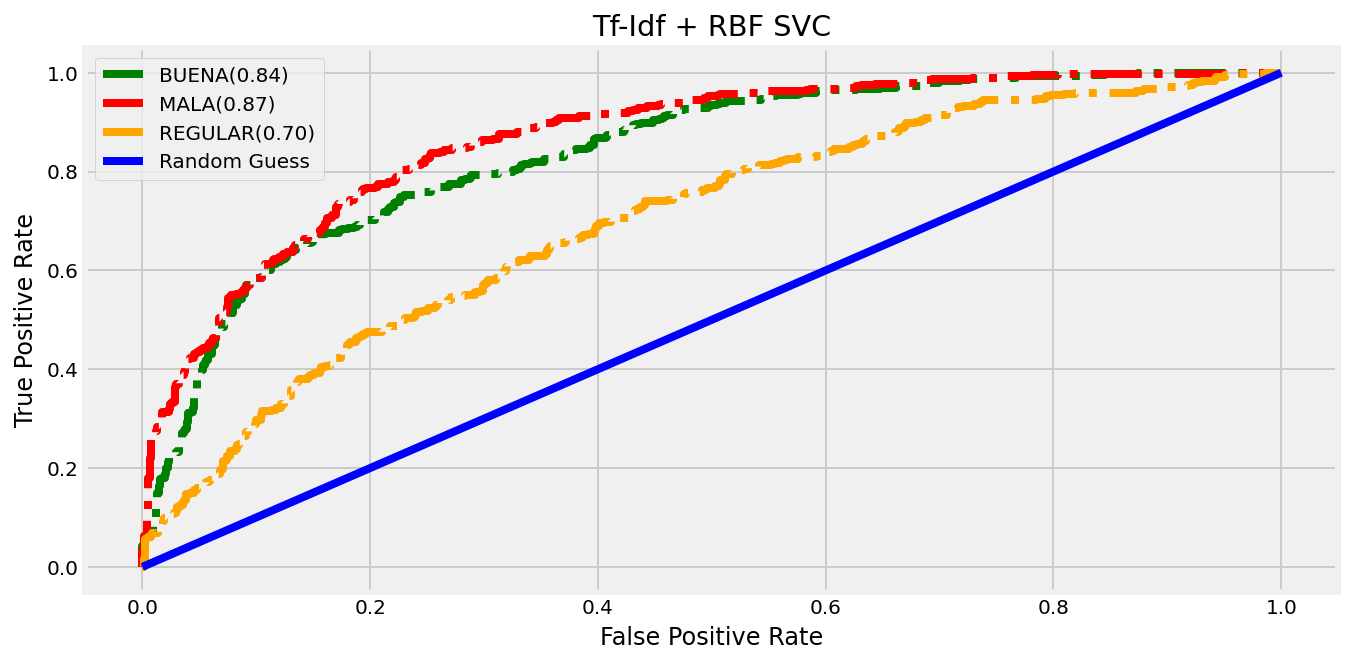

In [81]:
# Curvas ROC
plot_auc(y_test, prediccion_prob, labels, "Tf-Idf + RBF SVC")

**TF-IDF + RBF SVC (optimizado):**
Es un poco mejor que Naïve Bayes en rendimiento pero mucho más costoso de entrenar. **Hasta el momento es el que mejores resultados ha obtenido.**

## **Extracción de Word embeddings**
Definimos una clase objeto de tipo `streamed iterable` para recorrer las críticas. Después lo usaremos para generar los modelos para generar los embeddings.

Se calcularán varios tipos de Word Embeddings: 
- Un tipo basado en vectores de documento para usarlo en los mismos tipos de clasificadores que para las matrices sparse.
- Otro tipo de embeddings usando la librería `Keras` para usarlos sobre un modelo CNN. 
Aplicamos una primera capa de embeddings para convertir las palabras en vectores y luego entrenamos con una red CNN (seleccionando el max-pooling de cada filtro para obtener un vector por tweet).
Para calcular los embeddings usamos:  
 - Una capa de embeddings propia sobre las criticas.
 - Transfer Learning con los word embeddings de spaCy.

In [201]:
# Se define el iterador como una clase, 
# se diferencia de un simple generator en que se puede reiniciar
class PreprocesaCriticasClass(object):
    """Pre-procesa el corpus de críticas con la función de la librería gensim
    Entrada: directorio de críticas
    Salida: iterador sobre las críticas (como lista de tokens)"""
    def __init__(self, dirname):
        # variable interna de la clase para el dir
        self.dirname = dirname
 
    # Necesario definir metodo __iter__
    def __iter__(self):
        for c in parse_folder(self.dirname): # aqui se reinicia cada vez (empieza desde el principio)
          # Usamos mejor el criterio de usar el resumen si este es mayor que la crítica,
          if len(c[1]) > len(c[2]):
            yield normaliza(c[1], lemas=True)
          # Y para los casos en los que ambas esten vacías se eliminarían
          elif len(c[2]) == 0:
            continue   # Saltamos la(s) vacía(s)
          else:
            yield normaliza(c[2], lemas=True)

### **Modelos basados en word embeddings**
Se probarán dos modelos cada uno de ellos con un tipo de matriz embeddings diferente.
- Promediado de embeddings por documento: Paragraph Vectors + clasificador
- Red CNN con word embeddings de Spacy.


#### **Embeddings basados en ponderación de documento: Paragraph Vectors**


Calculamos el vector PV de cada critica para entrenar el clasificador con el modelo `Doc2vec`, calculamos los vectores PV sobre el conjunto de test.  
Referencia: https://radimrehurek.com/gensim/models/doc2vec.html

In [202]:
import gensim
import numpy as np

# Obtenemos un listado de los tweets de entrenamiento tokenizados
def word_tokenize(text):
    return [token.text for token in nlp.tokenizer(text)]

In [203]:
# Aplicamos modelo PV-DM
from gensim.models.doc2vec import TaggedDocument

# Cálculo de los vectores de palabras Word2Vec
# Instanciamos un objeto para nuestro directorio
criticas = PreprocesaCriticasClass(path)

X_train = criticas
X_tagged_train = [TaggedDocument(word_tokenize(text), [str(index)]) for index, text in enumerate(X_train)]

In [204]:
X_tagged_train[0]

TaggedDocument(words=['gustar', 'cine', 'masa', 'pelicula', 'ver', 'mundo', 'parecer', 'coñazo', 'insufribl', 'porqué', 'prota', 'tonto', 'culo', 'suerte', 'peli', 'lograr', 'vencer', 'convertir', 'listo', 'chorrada', 'comienzo', 'pelicula', 'esfumar', 'arte', 'magia', 'volver', 'maduro', 'inteligente', 'peli', 'persona', 'huir', 'huir', 'dar', 'tiro', 'cabron', 'meter', 'par', 'actor', 'echar', 'él', 'comer', 'aparte', 'niña', 'viejo', 'metido', 'cuerpo', 'niña', 'ver', 'él', 'hablar', 'version', 'original', 'dar', 'él', 'freaks', 'cine', 'creerar', 'gracia', 'nena', 'puta', 'madre', 'causar', 'pavor', 'cria', 'persona', 'maduro', 'horroroso', 'niño', 'niño', 'ver', 'él', 'rol', 'asustar', 'hijo', 'adolescente', 'cruise', 'subnormal', 'dar', 'él', 'bofetada', 'ver', 'hueso', 'mano', 'fiel', 'reflejo', 'denominar', 'manipulacion', 'militar', 'chico', 'matar', 'bicho', 'ningun', 'arma', 'hale', 'loco', 'pensar', 'venga', 'saco', 'quereis', 'decir', 'fanatismo', 'locura', 'alguien', 'que

In [205]:
model_train_dm = gensim.models.Doc2Vec(X_tagged_train, vector_size=50, 
                                 alpha=0.025, 
                                 min_alpha=0.025,
                                 window=5, min_count=1, workers=4,
                                 dm=1, dbow_words=0, dm_concat=0) #modelo DM: distributed memory
model_train_dbow = gensim.models.Doc2Vec(X_tagged_train, vector_size=50,
                                 window=5, min_count=1, workers=4,
                                 alpha=0.025, 
                                 min_alpha=0.025,
                                 dm=0, dbow_words=1, dm_concat=0) ##modelo DBOW: distributed bag of words

In [206]:
model_train_dm.train(X_tagged_train, total_examples=len(X_tagged_train), epochs=200)
model_train_dm

In [207]:
model_train_dbow.train(X_tagged_train, total_examples=len(X_tagged_train), epochs=200)
model_train_dbow

In [208]:
model_train_dm.save("model_train_dm_Doc2Vec.model")
model_train_dbow.save("model_train_dbow_Doc2Vec.model")

In [209]:
#from gensim.models import Doc2Vec

#model_train_dm = Doc2Vec.load("model_train_dm_Doc2Vec.model")
#model_train_dbow = Doc2Vec.load("model_train_dbow_Doc2Vec.model")

In [210]:
len(model_train_dm.docvecs.doctags)

2714

In [211]:
len(model_train_dbow.docvecs.doctags)

2714

In [212]:
#Una vez entrenado podemos ver el vector de cada documento
model_train_dm.docvecs[0]

array([ 2.52207   ,  0.24627434,  0.8898306 ,  2.6328547 ,  2.7931478 ,
       -2.5117583 ,  4.3456206 , -1.7919255 , -4.311055  ,  1.514271  ,
        7.0291934 ,  0.22594059, -0.360565  , -7.4822454 , -1.6440045 ,
        2.782618  ,  3.3576465 ,  2.6607711 , -1.2735974 ,  2.7245846 ,
       -0.5224972 , -2.8247545 , -1.781163  ,  1.279977  , -0.19365254,
       -6.382553  , -4.053991  ,  0.08554255, -4.600325  ,  0.14832534,
        1.0559176 , -4.761608  , -0.04278255,  7.18369   , -2.0456703 ,
        4.326241  ,  0.44130713, -5.496434  ,  3.991414  ,  1.6440227 ,
        2.6733723 , -1.5467721 ,  6.537591  , -4.3846073 , -2.5222254 ,
       -0.69150716, -2.012154  , -0.85578626, -2.7740545 , -7.476388  ],
      dtype=float32)

In [213]:
#dMem - también podemos ver los word vectors de cada palabra con
model_train_dm.wv['director']

array([ 0.62847126, -0.9547305 , -0.6294629 , -0.7748415 , -0.59885657,
       -0.57715446,  0.191851  , -0.08171052, -1.329821  ,  0.03753147,
        0.82934487, -1.040506  , -0.27228224, -0.70631826,  0.84000707,
       -1.0033847 , -1.0458035 ,  0.10856767, -0.15673214, -0.449343  ,
        0.6249914 ,  0.55682606, -0.4818451 , -0.7312114 ,  0.59364533,
        0.7762596 , -0.3993619 ,  0.3976419 , -0.40001526, -0.46394253,
       -0.8980827 , -0.8228394 , -0.19516219, -0.86137545, -0.92849475,
       -0.297351  , -1.1062225 , -0.24479173,  0.42446205,  0.51340336,
       -1.2598684 , -1.0724064 , -0.2677345 , -1.320622  ,  0.875039  ,
       -0.8443271 , -0.49601078,  0.21124074,  0.20615415,  1.0612137 ],
      dtype=float32)

In [214]:
#dBow - también podemos ver los word vectors de cada palabra con
model_train_dbow.wv['director']

array([ 0.25261158,  0.04691148,  0.16887784, -0.18049547,  0.3579212 ,
        0.23756583,  0.4525318 , -0.04403593, -0.30832523,  0.23307621,
        0.22852321, -0.2812131 , -0.19572218, -1.1397411 ,  0.35246634,
        0.06993783, -0.23352799, -0.19184625,  0.61637044,  0.08670811,
        0.00271093,  0.01730164, -0.5691979 ,  0.14261296,  0.23333432,
       -0.44092053, -0.48030224,  0.33548987, -0.09279849,  0.5820556 ,
        0.17798153, -0.15110858, -0.06894781,  0.13600765,  0.06627364,
       -0.1342845 , -0.01751128,  0.16751423,  0.23058671,  0.01483676,
        0.16932462,  0.19421162, -0.40942144, -0.12045603, -0.09204058,
       -0.57040215, -0.26196727, -0.23060133,  0.29131928, -0.0345324 ],
      dtype=float32)

Sólo guarda los vectores de palabra si se usa el modelo *distributed bag of words* con la opción dm=0

In [215]:
#Nos quedamos con el modelo ya entrenado en ambos casos para reducir el tamaño en memoria
model_train_dm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_train_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

##### **Seleccion de clasificador para Paragraph Vectors**
Vamos a usar como características de entrada el vector PV de cada crítica.  
Hemos definido que este vector tiene 50 dimensiones.

Para ver el rendimiento del modelo usamos el conjunto de test. Primero transformamos el conjunto de test a su modelo PV mediante el vectorizador aprendido en TRAIN y aplicamos sobre el modelo clasificador entrenado:

In [216]:
# creamos los modelos
modelos = [('Logistic Regression', LogisticRegression()),
           ('Naive Bayes', GaussianNB()),
           ('Linear SVM', SGDClassifier(loss='hinge', max_iter=10000, tol=1e-5)),
           ('RFB SVM', SVC(gamma='scale', C=2))]

In [217]:
#Construimos los vectores de entrenamiento y test con doc vectors
#estamos usando vectores de 50 dimensiones
#Inicializamos la matriz de características de entrada para el conjunto de entrenamiento
doc_vect_train=np.zeros((len(resumen), 50))

**Para PV calculado con Distributed Memory**

In [218]:
for i in range(len(model_train_dm.docvecs)):
    doc_vect_train[i,:]=model_train_dm.docvecs[i] #los vectores model_pv.docvecs[str(i)] NO funcionan

In [219]:
doc_vect_train.shape

(2714, 50)

In [220]:
#Matriz de características del conjunto de test
#los vectores PV no existen, hay que inferirlos con el modelo dist. Memory
doc_vect_test=np.zeros((len(X_test), 50))
for i,doc in enumerate(X_test):
    doc_vect_test[i,:]=model_train_dm.infer_vector(word_tokenize(doc), steps=150)
    
doc_vect_test.shape

(1164, 50)

In [221]:
#dMem - entrenamos, predecimos y evaluamos clasificadores con modelos word embeddings 
for m, clf in modelos:
    print('Modelo {} con características Paragraph Vectors'.format(m))
    pv_dm_predictions = train_predict_evaluate_model(classifier=clf,
                                           train_features=doc_vect_train,
                                           train_labels=y_train,
                                           test_features=doc_vect_test,
                                           test_labels=y_test) 

Modelo Logistic Regression con características Paragraph Vectors
              precision    recall  f1-score   support

       BUENA       0.53      0.73      0.62       395
        MALA       0.55      0.70      0.62       395
     REGULAR       0.48      0.16      0.23       374

    accuracy                           0.54      1164
   macro avg       0.52      0.53      0.49      1164
weighted avg       0.52      0.54      0.49      1164

Modelo Naive Bayes con características Paragraph Vectors
              precision    recall  f1-score   support

       BUENA       0.50      0.64      0.56       395
        MALA       0.56      0.60      0.58       395
     REGULAR       0.40      0.25      0.31       374

    accuracy                           0.50      1164
   macro avg       0.49      0.50      0.48      1164
weighted avg       0.49      0.50      0.49      1164

Modelo Linear SVM con características Paragraph Vectors
              precision    recall  f1-score   support

     

No mejoran a los anteriores Sparse TF-IDF

**Repetimos con las PV calculados con el modelo DBOW:**

In [222]:
#Dbow - entrenamos, predecimos y evaluamos clasificadores con modelos word embeddings 
for i in range(len(model_train_dbow.docvecs)):
    doc_vect_train[i,:]=model_train_dbow.docvecs[i]
    
for i,doc in enumerate(X_test):
    doc_vect_test[i,:]=model_train_dbow.infer_vector(word_tokenize(doc), steps=150)

for m, clf in modelos:
    print('Modelo {} con características Paragraph Vectors'.format(m))
    pv_dbow_predictions = train_predict_evaluate_model(classifier=clf,
                                           train_features=doc_vect_train,
                                           train_labels=y_train,
                                           test_features=doc_vect_test,
                                           test_labels=y_test)

Modelo Logistic Regression con características Paragraph Vectors
              precision    recall  f1-score   support

       BUENA       0.49      0.85      0.62       395
        MALA       0.62      0.56      0.59       395
     REGULAR       0.51      0.16      0.24       374

    accuracy                           0.53      1164
   macro avg       0.54      0.53      0.48      1164
weighted avg       0.54      0.53      0.49      1164

Modelo Naive Bayes con características Paragraph Vectors
              precision    recall  f1-score   support

       BUENA       0.40      0.94      0.56       395
        MALA       0.67      0.33      0.45       395
     REGULAR       0.58      0.05      0.09       374

    accuracy                           0.45      1164
   macro avg       0.55      0.44      0.36      1164
weighted avg       0.55      0.45      0.37      1164

Modelo Linear SVM con características Paragraph Vectors
              precision    recall  f1-score   support

     

No mejoran a los anteriores Sparse TF-IDF

#### **Clasificador CNN**
Implementemos un clasificador con Convolutional Neural Networks aplicado al análisis de sentimiento en Twitter usando la librería `Keras`.  
Aplicamos una primera capa de embeddings para convertir las palabras en vectores y luego entrenamos con una red CNN (seleccionando el max-pooling de cada filtro para obtener un vector por tweet).  
Para calcular los embeddings usamos:  
- Una capa de embeddings propia sobre los tweets
- Transfer Learning con los word embeddings de spaCy (GloVe) 

Implementado según el modelo planteado en [Convolutional Neural Networks for Sentence Classification](http://arxiv.org/abs/1408.5882)

In [223]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [224]:
!pip -q install https://github.com/explosion/spacy-models/releases/download/es_core_news_md-3.0.0/es_core_news_md-3.0.0.tar.gz

     |████████████████████████████████| 44.0MB 70kB/s 


In [225]:
nlp=spacy.load('es_core_news_md')

Preparacion del conjunto de datos

In [292]:
#hay que convertir a numérico el conjunto de etiquetas para KerasMAX_SEQUENCE_LENGTH = X_train_CNN.shape[1]
#codificamos 'MALA' como 0 'REGULAR' como 1 y 'BUENA' como 2
label_values = {'BUENA': 2,
                'REGULAR': 1,
                'MALA': 0}

y_train_CNN = np.array([label_values[label] for label in y_train])

# Comprobamos
y_train_CNN[:5]

array([0, 0, 1, 2, 0])

In [293]:
y_train[:5]

0       MALA
1       MALA
2    REGULAR
3      BUENA
4       MALA
Name: Valoracion, dtype: object

In [294]:
# Comprobamos 
y_train_CNN[-5:]

array([2, 2, 0, 0, 2])

In [295]:
# Comprobamos 
y_train[-5:]

2709    BUENA
2710    BUENA
2711     MALA
2712     MALA
2713    BUENA
Name: Valoracion, dtype: object

In [296]:
len(y_train) == len(y_train_CNN)

True

In [300]:
# Convertimos etiquetas de conjunto de test
y_test_CNN = np.array([label_values[label] for label in y_test])

#Comprobamos
y_test_CNN[:5]

array([1, 2, 0, 0, 1])

In [301]:
y_test[:5]

0    REGULAR
1      BUENA
2       MALA
3       MALA
4    REGULAR
Name: Valoracion, dtype: object

In [302]:
# Comprobamos 
y_test_CNN[-5:]

array([1, 0, 2, 1, 1])

In [303]:
y_test[-5:]

1159    REGULAR
1160       MALA
1161      BUENA
1162    REGULAR
1163    REGULAR
Name: Valoracion, dtype: object

In [304]:
# Dimension de los vectores
tokenizer_CNN = Tokenizer(split=' ')
criticas = PreprocesaCriticasClass(path)

In [305]:
# Convertir frase en identificadores unicos de palabras
tokenizer_CNN.fit_on_texts(criticas)
tokenizer_CNN

In [306]:
# saving
with open('tokenizer_CNN.pickle', 'wb') as handle:
    pickle.dump(tokenizer_CNN, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [307]:
# loading
#with open('tokenizer_CNN.pickle', 'rb') as handle:
#    tokenizer_CNN2 = pickle.load(handle)

In [308]:
 # Diccionario de conversion entre palabras-indices
word_index_CNN = tokenizer_CNN.word_index

In [309]:
# Aqui se convierten las palabras a indices para el conjunto de entrenamiento
X_train_CNN = tokenizer_CNN.texts_to_sequences(criticas) 
# Hacer q todo tenga la misma longitud
X_train_CNN = pad_sequences(X_train_CNN, padding='post')

# saving
with open('X_train_CNN.pickle', 'wb') as handle:
    pickle.dump(X_train_CNN, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [310]:
print(f'Número de tokens distintos: {len(word_index_CNN)}')

Número de tokens distintos: 35440


Vocabulario de 35440 palabras distintas

In [311]:
MAX_SEQUENCE_LENGTH = X_train_CNN.shape[1]
MAX_SEQUENCE_LENGTH

1871

In [312]:
# Adding 1 because of  reserved 0 index
max_features = len(word_index_CNN)+1
max_features

35441

In [313]:
# Aqui se convierten las palabras a indices para el conjunto de test
X_test_CNN = tokenizer_CNN.texts_to_sequences(X_test)

In [314]:
X_test_CNN = pad_sequences(X_test_CNN, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

# saving
with open('X_test_CNN.pickle', 'wb') as handle:
    pickle.dump(X_test_CNN, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [315]:
# Como esta critica es de menos d 30 palabras se rellena con 0's
X_train_CNN[1000]

array([1087, 1106,   51, ...,    0,    0,    0], dtype=int32)

In [316]:
print(X_train_CNN.shape, y_train_CNN.shape)
print(X_test_CNN.shape, y_test_CNN.shape)

(2714, 1871) (2714,)
(1164, 1871) (1164,)


##### Word embeddins propios
Entrenamos una capa de embedding para aprender los WE con los textos de nuestro problema.

In [361]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, Activation, Conv1D, GlobalMaxPooling1D

#Creamos el modelo CNN en Keras CONV1D
#Usamos como referencia el ejemplo de Keras: https://github.com/keras-team/keras/blob/master/examples/imdb_cnn.py
#pero quitamos la capa oculta intermedia para simplificar el modelo y dejarlo como en el artículo

#Parámetros de la red
embed_dim = 50    # Word embeddings de 50 palabras
filters = 64      # 64 filtros 
kernel_size = 3   # cada filtro de 5 (desplazarse de 5 en 5 palabras)

model = Sequential()

#  En esta capa es importante decirle el tamaño del vocab, porque esto le dice cuales son las palabras que va a aprender (MAX_FEATS * EMBED_DIMS)
model.add(Embedding(max_features, embed_dim, input_length = MAX_SEQUENCE_LENGTH)) # Capa de embeddings, es la que va a aprender esa conversion de ids de vectores numericos de 50 dims
model.add(Dropout(0.2))

# añadimos una capa de convolución 1D que aprende
# filtros de grupos de palabras de tamaño kernel_size
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

# calculamos el max pooling:
# GlobalMaxPooling1D 
model.add(GlobalMaxPooling1D())
#model.add(Dense(50, activation='relu'))
#model.add(Dropout(0.4))

# conectamos a una capa de salida de una unidad con activación softmax (problema multiclase)
model.add(Dense(3))
model.add(Activation('softmax'))

# compilamos el modelo
model.compile(loss='SparseCategoricalCrossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 1871, 50)          1772050   
_________________________________________________________________
dropout_34 (Dropout)         (None, 1871, 50)          0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 1869, 64)          9664      
_________________________________________________________________
global_max_pooling1d_21 (Glo (None, 64)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 3)                 195       
_________________________________________________________________
activation_18 (Activation)   (None, 3)                 0         
Total params: 1,781,909
Trainable params: 1,781,909
Non-trainable params: 0
___________________________________________

In [362]:
batch_size = 32
history = model.fit(X_train_CNN, y_train_CNN, epochs=15, batch_size=batch_size, verbose=2, validation_data=(X_test_CNN, y_test_CNN))

Epoch 1/15
85/85 - 18s - loss: 1.0979 - accuracy: 0.3460 - val_loss: 1.0920 - val_accuracy: 0.4407
Epoch 2/15
85/85 - 17s - loss: 1.0559 - accuracy: 0.6256 - val_loss: 1.0750 - val_accuracy: 0.4175
Epoch 3/15
85/85 - 18s - loss: 0.9723 - accuracy: 0.6853 - val_loss: 1.0311 - val_accuracy: 0.4923
Epoch 4/15
85/85 - 17s - loss: 0.8168 - accuracy: 0.8084 - val_loss: 0.9781 - val_accuracy: 0.5180
Epoch 5/15
85/85 - 18s - loss: 0.6018 - accuracy: 0.8979 - val_loss: 0.9449 - val_accuracy: 0.5215
Epoch 6/15
85/85 - 17s - loss: 0.3699 - accuracy: 0.9661 - val_loss: 0.9382 - val_accuracy: 0.5275
Epoch 7/15
85/85 - 17s - loss: 0.1945 - accuracy: 0.9934 - val_loss: 0.9499 - val_accuracy: 0.5352
Epoch 8/15
85/85 - 17s - loss: 0.0968 - accuracy: 0.9993 - val_loss: 0.9800 - val_accuracy: 0.5284
Epoch 9/15
85/85 - 17s - loss: 0.0509 - accuracy: 1.0000 - val_loss: 1.0032 - val_accuracy: 0.5404
Epoch 10/15
85/85 - 17s - loss: 0.0308 - accuracy: 1.0000 - val_loss: 1.0257 - val_accuracy: 0.5318
Epoch 11/

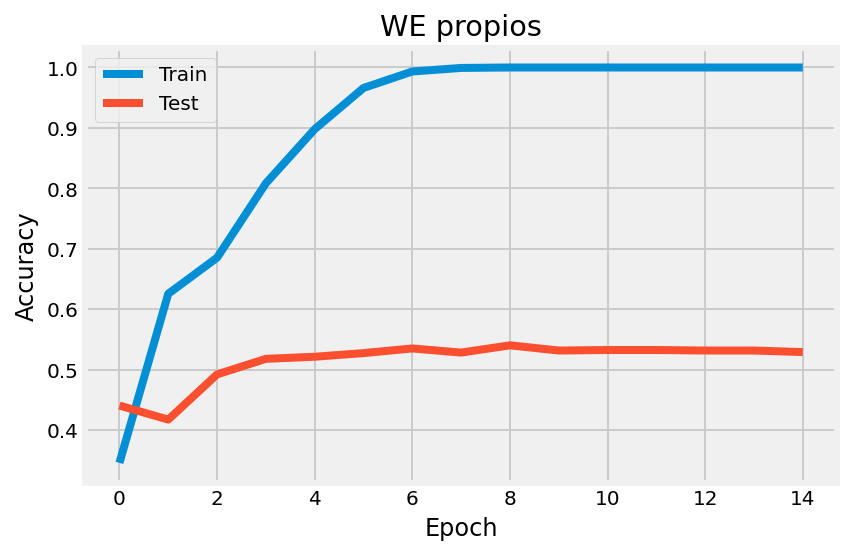

In [363]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('WE propios')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [365]:
score,acc = model.evaluate(X_test_CNN, y_test_CNN, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

37/37 - 1s - loss: 1.1065 - accuracy: 0.5292
score: 1.11
acc: 0.53


In [366]:
from sklearn.metrics import classification_report

print(classification_report(y_test_CNN, np.argmax(model.predict(X_test_CNN, batch_size=1), axis=-1)))

              precision    recall  f1-score   support

           0       0.63      0.57      0.60       395
           1       0.41      0.48      0.44       374
           2       0.57      0.53      0.55       395

    accuracy                           0.53      1164
   macro avg       0.54      0.53      0.53      1164
weighted avg       0.54      0.53      0.53      1164



**No mejora los mejores resultados anteriores pero se mantiene en la linea.**

##### **Word embeddings de spaCy**
Aplicamos Transfer Learning usando los embeddings GloVe incluidos en el modelo de spaCy.

La primera capa aprende los embeddings, si usamos embeddings mas informativos posiblemente el modelo generalizara mejor. Los embeddings son una matriz de pesos, si en vez de aprenderlos se los damos ya generados externamente (por ejemplo los de Spacy que son de dimension 300).

In [351]:
nlp = spacy.load("es_core_news_md")

In [352]:
#Rellenamos los vectores con el valor en spaCy para nuestro vocabulario
EMBEDDING_DIM = nlp.vocab.vectors_length

embedding_matrix_CNN = np.zeros((max_features, EMBEDDING_DIM))
for word, i in word_index_CNN.items():
    if(i > max_features):
        break
    embedding_vector = nlp.vocab[word].vector
    if embedding_vector is not None:
        # las palabras que no están en spaCy serán cero.
        embedding_matrix_CNN[i] = np.array(embedding_vector, dtype=np.float32)#[:EMBEDDING_DIM]

In [353]:
embedding_matrix_CNN.shape

(35441, 300)

In [356]:
#Creamos el modelo CNN en Keras

#parámetros de la red
filters = 64
kernel_size = 3
EMBEDDING_DIM = nlp.vocab.vectors_length

embedding_layer = Embedding(max_features,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_CNN],  # Le indicamos esa matriz
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)  # Transfer learning: Usa esa matriz como valores iniciales 
                                             # pero le indico que ajuste esos pesos a mi conjunbto de datos especifico (entrenable)
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))

# añadimos una capa de convolución 1D que aprende
# filtros de grupos de palabras de tamaño kernel_size
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

# calculamos el max pooling:
# GlobalMaxPooling1D 
model.add(GlobalMaxPooling1D())
#model.add(Dense(50, activation='relu'))
#model.add(Dropout(0.4))

# conectamos a una capa de salida de una unidad con activación softmax (problema multiclase)
model.add(Dense(3))
model.add(Activation('softmax'))

# compilamos el modelo
model.compile(loss='SparseCategoricalCrossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 1871, 300)         10632300  
_________________________________________________________________
dropout_33 (Dropout)         (None, 1871, 300)         0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 1869, 64)          57664     
_________________________________________________________________
global_max_pooling1d_20 (Glo (None, 64)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 3)                 195       
_________________________________________________________________
activation_17 (Activation)   (None, 3)                 0         
Total params: 10,690,159
Trainable params: 10,690,159
Non-trainable params: 0
_________________________________________

In [357]:
batch_size = 32
history = model.fit(X_train_CNN, y_train_CNN, epochs=15, batch_size=batch_size, verbose=2, validation_data=(X_test_CNN, y_test_CNN))

Epoch 1/15
85/85 - 84s - loss: 2.6443 - accuracy: 0.3629 - val_loss: 2.1054 - val_accuracy: 0.3565
Epoch 2/15
85/85 - 83s - loss: 1.6108 - accuracy: 0.4687 - val_loss: 1.9520 - val_accuracy: 0.3729
Epoch 3/15
85/85 - 83s - loss: 1.3152 - accuracy: 0.5335 - val_loss: 1.6515 - val_accuracy: 0.4235
Epoch 4/15
85/85 - 83s - loss: 1.1772 - accuracy: 0.5637 - val_loss: 1.7001 - val_accuracy: 0.4012
Epoch 5/15
85/85 - 82s - loss: 0.9000 - accuracy: 0.6455 - val_loss: 1.9052 - val_accuracy: 0.4107
Epoch 6/15
85/85 - 82s - loss: 0.7452 - accuracy: 0.7093 - val_loss: 1.6406 - val_accuracy: 0.4390
Epoch 7/15
85/85 - 83s - loss: 0.6913 - accuracy: 0.7251 - val_loss: 1.7265 - val_accuracy: 0.4184
Epoch 8/15
85/85 - 84s - loss: 0.5620 - accuracy: 0.7775 - val_loss: 1.6531 - val_accuracy: 0.4493
Epoch 9/15
85/85 - 84s - loss: 0.5407 - accuracy: 0.7793 - val_loss: 1.7502 - val_accuracy: 0.4450
Epoch 10/15
85/85 - 84s - loss: 0.3984 - accuracy: 0.8405 - val_loss: 1.7424 - val_accuracy: 0.4450
Epoch 11/

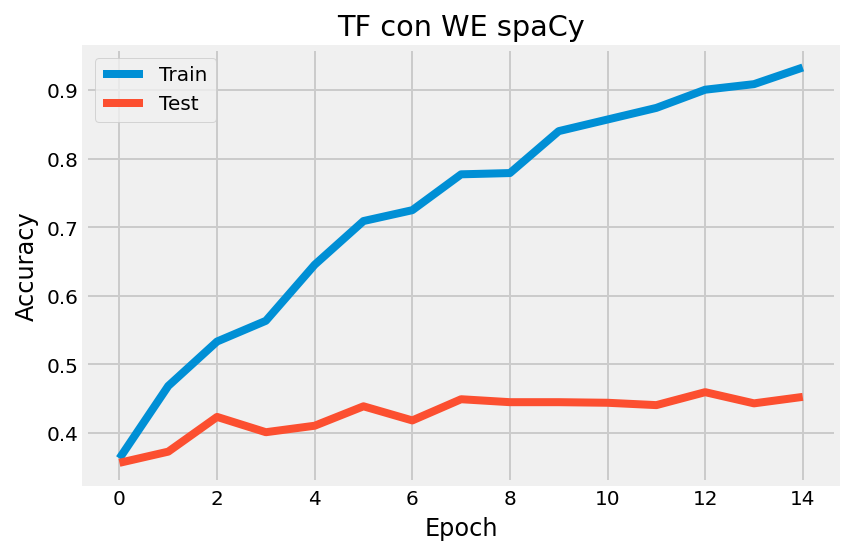

In [358]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('TF con WE spaCy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [359]:
score,acc = model.evaluate(X_test_CNN, y_test_CNN, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

37/37 - 6s - loss: 1.9349 - accuracy: 0.4527
score: 1.93
acc: 0.45


In [360]:
from sklearn.metrics import classification_report

print(classification_report(y_test_CNN, np.argmax(model.predict(X_test_CNN), axis=-1)))

              precision    recall  f1-score   support

           0       0.50      0.52      0.51       395
           1       0.38      0.55      0.45       374
           2       0.54      0.29      0.38       395

    accuracy                           0.45      1164
   macro avg       0.47      0.45      0.45      1164
weighted avg       0.48      0.45      0.45      1164



En ambos casos **el rendimiento con CNN no es mucho peor que cualquiera de los modelos anteriores**, funcionando mejor la de vectores propios, que además es más simple al no tener esa entrada de mas de 10M de parámetros dada por el uso de embeddings de spaCy con 300 dimensiones.

## Extracción de Topic Space Vector Model: LSA
Ahora vamos a utilizar un modelo de reducción de la dimensionalidad LSA para clasificar con conjunto de críticas.


### Modelo LSA
Creamos un procesado `pipeline` para calcular la matriz TF-IDF y a partir de esta el modelo LSA

In [368]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

# Generador con normalizacion y lematización ya usado en el modelo CNN
criticas = PreprocesaCriticasClass(path)

vect = TfidfVectorizer() #vectorizar
svd = TruncatedSVD(n_components=500) # reducir dim a 500

modelo = make_pipeline(vect, svd, Normalizer(copy=False))
#Entrenamos el modelo con el conjunto de train
lsa_train = modelo.fit_transform(criticas) # fit_transform hace las 3 cosas

In [369]:
# saving
with open('lsa_train.pickle', 'wb') as handle:
    pickle.dump(lsa_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [370]:
# num criticas X 500 componentes (dimension reducida)
lsa_train.shape

(2714, 500)

In [371]:
# TfidfVectorizer es modelo[0]
# 35373 terminos, reduccion de (2714 x 500), en modo denso en vez d Sparse
len(modelo[0].get_feature_names())

35373

In [372]:
# vector LSA de 38581 terminos en 500 dimensiones para cada una de las 1164 criticas de test
X_test = resumen_test['Critica_Normalizada']
lsa_test = modelo.transform(X_test)
lsa_test.shape

(1164, 500)

In [373]:
# creamos los modelos
modelos = [('Logistic Regression', LogisticRegression()),
           ('Naive Bayes', GaussianNB()), # Gaussian permite negativos
           ('Linear SVM', SGDClassifier(loss='hinge', max_iter=10000, tol=1e-5)),
           ('RFB SVM', SVC(gamma='scale', C=2))]

In [374]:
#entrenamos, predecimos y evaluamos clasificadores con modelos lsa
for m, clf in modelos:
    print('Modelo {} con características LSA 500 dims'.format(m))
    lsa_predictions = train_predict_evaluate_model(classifier=clf,
                                           train_features=lsa_train,
                                           train_labels=y_train,
                                           test_features=lsa_test,
                                           test_labels=y_test) 


Modelo Logistic Regression con características LSA 500 dims
              precision    recall  f1-score   support

       BUENA       0.54      0.82      0.65       395
        MALA       0.74      0.60      0.66       395
     REGULAR       0.51      0.34      0.41       374

    accuracy                           0.59      1164
   macro avg       0.60      0.58      0.57      1164
weighted avg       0.60      0.59      0.58      1164

Modelo Naive Bayes con características LSA 500 dims
              precision    recall  f1-score   support

       BUENA       0.37      0.94      0.53       395
        MALA       0.78      0.12      0.20       395
     REGULAR       0.49      0.15      0.23       374

    accuracy                           0.41      1164
   macro avg       0.55      0.40      0.32      1164
weighted avg       0.55      0.41      0.32      1164

Modelo Linear SVM con características LSA 500 dims
              precision    recall  f1-score   support

       BUENA       0

**Funciona mas o menos igual que los anteriores pero son mas rapidos al tener menos dimensiones**

Una vez establecido el mejor modelo de clasificación a utilizar podemos integrar todos los paso en el `pipeline`:

In [375]:
# Vimos q el mejor es el SVM con Kernel Gaussiano
vect = TfidfVectorizer()
svd = TruncatedSVD(n_components=500)
modelSVM = SVC(gamma='scale', C=2)

modelo = make_pipeline(vect, svd, Normalizer(copy=False), modelSVM)
#Entrenamos el modelo con el conjunto de train
modelo.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token...
                 TruncatedSVD(algorithm='randomized', n_components=500,
                              n_iter=5, random_state=None, tol=0.0)),
                ('normalizer', Normalizer(copy=False, norm='l2')),
                ('svc',
                 SVC(C=2, break_ties=False, cache_size=200, class_wei

In [376]:
prediccion = modelo.predict(X_test)
print(classification_report(y_test, prediccion))

              precision    recall  f1-score   support

       BUENA       0.56      0.82      0.66       395
        MALA       0.75      0.57      0.65       395
     REGULAR       0.50      0.38      0.43       374

    accuracy                           0.59      1164
   macro avg       0.60      0.59      0.58      1164
weighted avg       0.60      0.59      0.58      1164



Aqui no hay tanta importancia en quitar términos pues al reducr dim ya quita terminos.

**Vamos a jugar un poco con el numero de dimensiones**, probaremos con 100. 750 y 1500 a ver si mejora los resultados de esas 500 dimensionmes.


In [377]:
# Con pocas empeora
vect = TfidfVectorizer()
svd = TruncatedSVD(n_components=100)
modelSVM = SVC(gamma='scale', C=2)

modelo = make_pipeline(vect, svd, Normalizer(copy=False), modelSVM)
#Entrenamos el modelo con el conjunto de train
modelo.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token...
                 TruncatedSVD(algorithm='randomized', n_components=100,
                              n_iter=5, random_state=None, tol=0.0)),
                ('normalizer', Normalizer(copy=False, norm='l2')),
                ('svc',
                 SVC(C=2, break_ties=False, cache_size=200, class_wei

In [378]:
prediccion = modelo.predict(X_test)
print(classification_report(y_test, prediccion))

              precision    recall  f1-score   support

       BUENA       0.57      0.74      0.64       395
        MALA       0.71      0.57      0.63       395
     REGULAR       0.48      0.43      0.45       374

    accuracy                           0.58      1164
   macro avg       0.58      0.58      0.57      1164
weighted avg       0.59      0.58      0.58      1164



Con 100 no mejora a 500.

In [379]:
# Con muchas tambien empeora un poco
vect = TfidfVectorizer()
svd = TruncatedSVD(n_components=1500)
modelSVM = SVC(gamma='scale', C=2)

modelo = make_pipeline(vect, svd, Normalizer(copy=False), modelSVM)
#Entrenamos el modelo con el conjunto de train
modelo.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token...
                 TruncatedSVD(algorithm='randomized', n_components=1500,
                              n_iter=5, random_state=None, tol=0.0)),
                ('normalizer', Normalizer(copy=False, norm='l2')),
                ('svc',
                 SVC(C=2, break_ties=False, cache_size=200, class_we

In [380]:
prediccion = modelo.predict(X_test)
print(classification_report(y_test, prediccion))

              precision    recall  f1-score   support

       BUENA       0.55      0.82      0.66       395
        MALA       0.77      0.56      0.65       395
     REGULAR       0.49      0.38      0.43       374

    accuracy                           0.59      1164
   macro avg       0.60      0.58      0.58      1164
weighted avg       0.60      0.59      0.58      1164



Con 1500 es prácticamente igual que con 500, incluso algo peor. **Preferimos 500 al ser menor y su modelo más sencillo.**

In [381]:
# Con muchas tambien empeora 
vect = TfidfVectorizer()
svd = TruncatedSVD(n_components=750)
modelSVM = SVC(gamma='scale', C=2)

modelo = make_pipeline(vect, svd, Normalizer(copy=False), modelSVM)
#Entrenamos el modelo con el conjunto de train
modelo.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token...
                 TruncatedSVD(algorithm='randomized', n_components=750,
                              n_iter=5, random_state=None, tol=0.0)),
                ('normalizer', Normalizer(copy=False, norm='l2')),
                ('svc',
                 SVC(C=2, break_ties=False, cache_size=200, class_wei

In [382]:
prediccion = modelo.predict(X_test)
print(classification_report(y_test, prediccion))

              precision    recall  f1-score   support

       BUENA       0.55      0.82      0.66       395
        MALA       0.76      0.59      0.66       395
     REGULAR       0.48      0.34      0.40       374

    accuracy                           0.59      1164
   macro avg       0.60      0.58      0.57      1164
weighted avg       0.60      0.59      0.58      1164



No se aprecian notables diferencias al uso de 5oo dimensiones, por lo que **nos quedamos con las 500 dimensiones**.


##### **LSA + RBF SVM**
Vamos a tratar de optimizarlo con GridSearch para ver si mejoraría a su versión análoga con Tf-Idf.





Entrenamiento del modelo:

In [389]:
# Tratamos de optimizar hiperparametros con GridSearch
param_grid = {'C': [2.0, 1.0],
              'degree':[2, 3],
              'tol': [0.001, 0.0001],
              'probability': [True]} # Para sacar predict_proba para las ROC

modelSVC_LSA = SVC(gamma='scale')
cv = GridSearchCV(modelSVC_LSA, param_grid, cv=5, n_jobs=-1)

#Entrenamos el modelo con el conjunto de train por GridSearch y nos quedamos con el mejor
cv.fit(lsa_train, y_train)
cv.cv_results_
modelSVC_LSA = cv.best_estimator_

In [390]:
modelSVC_LSA

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [391]:
modelSVC_LSA = cv.best_estimator_.fit(lsa_train, y_train)

In [394]:
prediccion = modelSVC_LSA.predict(lsa_test)

#5 primeras preds
prediccion[:5]

array(['MALA', 'MALA', 'BUENA', 'MALA', 'REGULAR'], dtype=object)

Exactitud del modelo
(Núm. predicciones correctas / Total de muestras)

In [396]:
from sklearn.metrics import accuracy_score

# Exactitud (accuracy) <> Precisón  
print('Exactitud: ', accuracy_score(y_test, prediccion))

Exactitud:  0.570446735395189


Matriz de confusión (predicción -columnas- frente a etiquetas reales -filas-)

In [397]:
# Chequeamos el orden de las etiquetas en el modelo
labels = list(modelSVC_TfIdf.classes_)
labels

['BUENA', 'MALA', 'REGULAR']

In [398]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_test, prediccion)
pd.DataFrame(cm, index=('BUENA_true','MALA_true', 'REGULAR_true'), columns=('BUENA_true','MALA_true', 'REGULAR_true'))
#filas: True, columnas: Prediction

,BUENA_true,MALA_true,REGULAR_true
BUENA_true,323,21,51
MALA_true,99,212,84
REGULAR_true,189,56,129


Podemos ver un informe más completo del clasificador con la métrica `classification_report`:

In [399]:
from sklearn.metrics import classification_report

print(classification_report(y_test, prediccion))

              precision    recall  f1-score   support

       BUENA       0.53      0.82      0.64       395
        MALA       0.73      0.54      0.62       395
     REGULAR       0.49      0.34      0.40       374

    accuracy                           0.57      1164
   macro avg       0.58      0.57      0.56      1164
weighted avg       0.59      0.57      0.56      1164



Área bajo la curva ROC:  
Para calcular el área bajo la curva ROC (AUC) es necesario obtener la probabilidad de salida del clasificador con `predict_proba`

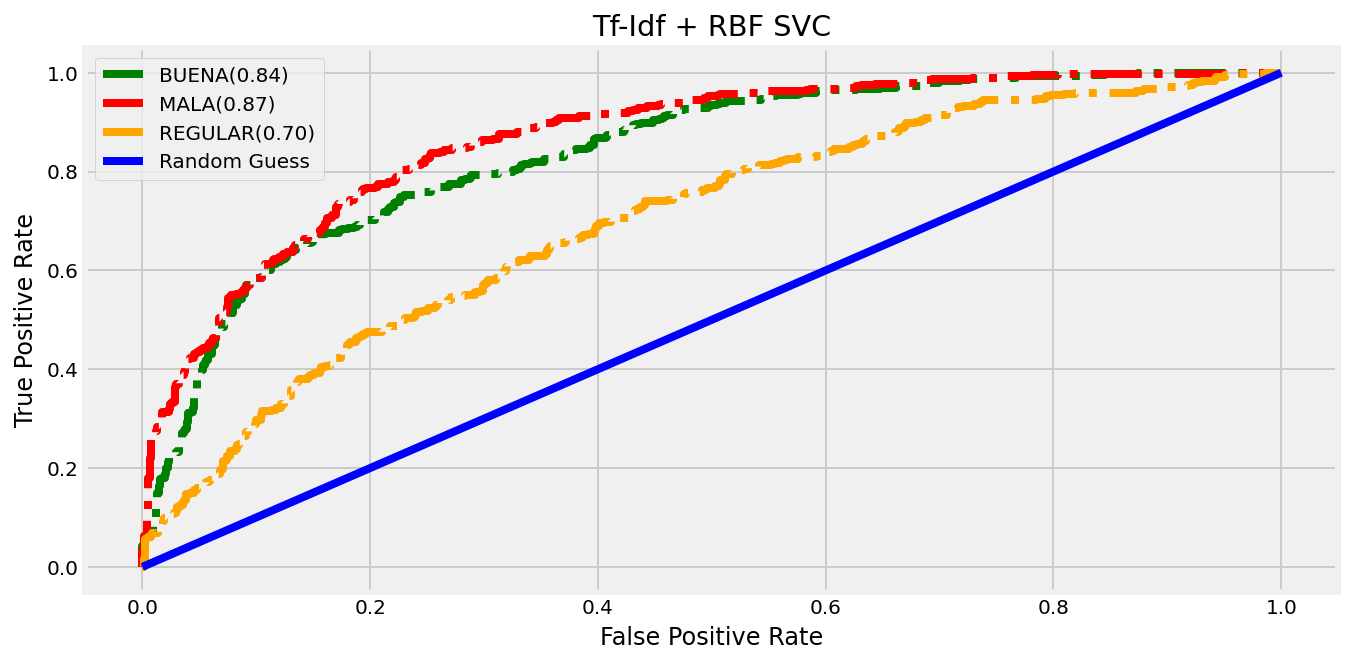

In [401]:
prediccion_prob = modelSVC_TfIdf.predict_proba(vect_TfIdf.transform(X_test))
# Curvas ROC 
plot_auc(y_test, prediccion_prob, labels, "Tf-Idf + RBF SVC")

Pese a todo no es mejor que su versión con TF-IDF, por lo que nos quedaríamos con la otra.

# NOTAS/ MEJORAS
 - Probar con correccion de texto antes de generar el normalizado, este para Español no funciona muy bien como podemos ver más abajo.

 Referencia: https://spacy.io/universe/project/contextualSpellCheck

In [ ]:
!pip install contextualSpellCheck

In [ ]:
import spacy
import contextualSpellCheck

nlp = spacy.load('es_core_news_md')
contextualSpellCheck.add_to_pipe(nlp)
doc = nlp('Hola, buenod dias')

print(doc._.performed_spellCheck) #Should be True
print(doc._.outcome_spellCheck) 

- Filtrar por POS-tags, permitir solo un subconjunto de ellos donde los ADJ estén presentes, esto habría estado bien probarlo algo parecido a `allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']` en la funcion de normalización, pero ha faltado tiempo.




Entrega de los ejercicios:
- Debes ejecutar cada ejercicio en un notebook separado. 
- Entrega como solución el notebook ya ejecutado y exportado como HTML.